## Outliers analysis

### Criterios
- Percentiles: Revisar valores por debajo del P5 o por encima del P95
- Cuartiles:  valores < (Q1 - 3 * IQR) o valores > (Q3 + 3 * IQR)

- Dentro de la librería **PyOD** (Python Outlier Detection) está el algotirmo **COPOD** (Completely Outlier Detection based on the P-value of the Mahalanobis distance) que se puede usar para detectar outliers. Usar COPOD(contamination=0.01), para crear una instancia del modelo COPOD con un parámetro de contaminación del 0.0x y que el modelo identifique el x% de los datos como outliers

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#!pip install pyod

In [4]:
import io
import os
import json
import pickle
import joblib
import datetime
import numpy as np
import pandas as pd
import datetime as dt
import time

from tqdm import tqdm
from google.cloud import storage
from google.cloud import bigquery

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from datetime import datetime, timedelta
import matplotlib.cm as cm
from scipy import stats

from pyod.models.copod import COPOD

import warnings
warnings.filterwarnings("ignore")

In [5]:
# Read in parquet file
url = "/content/drive/MyDrive/UNR_2023/01.Open data/data_NMV_GAds_manipulated.parquet"
df_parquet = pd.read_parquet(url)

df_raw = df_parquet

In [6]:
df_raw.head(4)

week_day  month_day  year_day  month_year  is_event  is_cyber  \
date                                                                        
2022-01-17         1         17        17           1         0         0   
2022-01-18         2         18        18           1         0         0   
2022-01-19         3         19        19           1         0         0   
2022-01-20         4         20        20           1         0         0   

            previous_cyber_days    campaign  clicks  impressions  visitors  \
date                                                                         
2022-01-17                    0  Automotriz     354        39672        42   
2022-01-18                    0  Automotriz    1254       109474       763   
2022-01-19                    0  Automotriz    4344       124152      1032   
2022-01-20                    0  Automotriz    7231       413879      3120   

            visitors_pur  visits  orders  total_units_net  is_week_day  \
date                                                                     
2022-01-17             3      44       3                6            1   
2022-01-18            11     840      10               14            1   
2022-01-19            14    1216      14               32            1   
2022-01-20            38    3539      38               53            1   

            budget_USD  cost_USD  nmv_USD  
date                                       
2022-01-17      236.49     24.74    87.22  
2022-01-18      236.49     97.82   573.85  
2022-01-19      236.49    105.13  1037.57  
2022-01-20      236.49    694.31  2182.03

In [27]:
# Checking records after excluding outliers
df_ = df_raw.copy()
df_ = df_[df_.is_cyber == 0]
df_ = df_.drop(['is_cyber'], axis=1)
diff = df_raw.shape[0] - df_.shape[0]
print(f'Original data - Rows: {df_raw.shape[0]}\nExcluding cyber - Rows: {df_.shape[0]}\n      -> Number of records excluded:{diff}')

Original data - Rows: 6992
Excluding cyber - Rows: 6884
      -> Number of records excluded:108


#### Functions

In [ ]:
def drop_ol(df, contamination, ol_columns):
    '''
    Drop outliers from full datset.
        Parameters:
            df (DataFrame): Training data set per campaign.
            contamination (float): Fraction of outliers to be dropped.
            ol_columns (list): List of columns to be used as predictors
                in the outlier detecting algorithm.
        Returns:
            df (DataFrame): Clean (without outliers) dataset.
    '''
    # Exclude cyber days
    #df.reset_index(inplace=True)
    df = df[df.is_cyber == 0]
    df = df.drop(['is_cyber'], axis=1)

    # Dictionary
    percentiles = {}

    # Get Pi and P(1-i) percentiles values and save then into the dictionary
    for variable in ol_columns:
        P_lo = df[variable].quantile(contamination)
        P_up = df[variable].quantile(1 - contamination)
        percentiles[variable] = (P_lo, P_up)

    # Outliers
        P_lo, P_up = percentiles[variable]
        IQR = P_up - P_lo
        #df = df[(df[variable] >= P_lo-3*IQR) & (df[variable] <= P_up+3*IQR)]
        df = df[(df[variable] >= P_lo) & (df[variable] <= P_up)]
    return df#.reset_index(drop=True)

def drop_ol_campaigns(df_raw, contamination, ol_columns):
    '''
    Drop outliers from each campaign.
        Parameters:
            df_raw (DataFrame): Table with campaign's historical data.
            contamination (float): Expected fraction of outliers in the dataset.
            ol_columns (list): List with features to look at for ol detection.
        Returns:
            df (DataFrame): Table with campaign's historical data, without outliers.
    '''
    # Drop outliers
    df_list = []
    for campaign in tqdm(df_raw.campaign.unique(), total=df_raw.campaign.nunique()):
        # Filter input
        df = df_raw[df_raw['campaign'] == campaign].dropna()
        #df.reset_index(drop=True, inplace=True)
        df = drop_ol(df, contamination, ol_columns)
        df_list.append(df.copy())
    df = pd.concat(df_list)
    return df#.reset_index(drop=True)

In [11]:
## Funciones 2
def drop_ol2(df, contamination, ol_columns):
    '''
    Drop outliers from the whole datset.
        Parameters:
            df (DataFrame): Training data set per campaign.
            contamination (float): Fraction of outliers to be dropped.
            ol_columns (list): List of columns to be used as predictors
                in the outlier detecting algorithm.
        Returns:
            df (DataFrame): Clean (without outliers) dataset.
    '''
    # Outliers
    df['date'] = df.index
    df.reset_index(drop=True, inplace=True)
    df = df[df.is_cyber == 0]
    df = df.drop(['is_cyber'], axis=1)

    data = df[ol_columns].astype('float')
    data.reset_index(drop=True, inplace=True)
    model = COPOD(contamination=contamination)
    model.fit(data)
    df = df[~df.index.isin(np.where(model.predict(data)==1)[0])]
    return df.reset_index(drop=True)

def drop_ol_campaigns2(df_raw, contamination, ol_columns):
    '''
    Drop outliers from each campaign.
        Parameters:
            df_raw (DataFrame): Table with campaign's historical data.
            contamination (float): Expected fraction of outliers in the dataset.
            ol_columns (list): List with features to look at for ol detection.
        Returns:
            df (DataFrame): Table with campaign's historical data, without outliers.
    '''
    # Drop outliers
    df_list = []
    for campaign in tqdm(df_raw.campaign.unique(), total=df_raw.campaign.nunique()):
        # Filter input
        df = df_raw[df_raw['campaign']==campaign].dropna()
        #df.reset_index(drop=True, inplace=True)
        df = drop_ol2(df, contamination, ol_columns)
        df_list.append(df.copy())
    df = pd.concat(df_list)
    return df.reset_index(drop=True)

#### Parameters

In [ ]:
contamination = 0.005

ol_columns = ['budget_USD','cost_USD','nmv_USD', 'visitors_pur', 'orders']

#df = df_raw.copy()  # Create a copy of original dataframe

In [ ]:
# Drop outliers
df = drop_ol_campaigns(df_raw, contamination, ol_columns)

print(df.shape)

100%|██████████| 12/12 [00:00<00:00, 65.51it/s]

(6553, 18)


#### Different checkings

In [ ]:
count_df_raw = df_.groupby('campaign')['campaign'].agg('count') # Check outliers removed for no-cyber data
count_df_nout = df.groupby('campaign')['campaign'].agg('count')
diff = count_df_raw - count_df_nout
diff

campaign
Automotriz                                 24
Belleza_Bienestar                          28
Climatizacion                              29
Decoracion_Blanco                          30
Grandes_Electrodomesticos_Cocina           29
Grandes_Electrodomesticos_Lavado           30
Grandes_Electrodomesticos_Refrigeracion    30
Jardineria                                 28
Mascotas                                   23
Menaje                                     27
Pequeños_Electrodomesticos                 25
Telefonia                                  28
Name: campaign, dtype: int64

In [ ]:
diff = df_.shape[0] - df.shape[0]
print(f'Excluding cyber - Rows: {df_.shape[0]}\nExcluding outliers - Rows: {df.shape[0]}\n      -> Number of records excluded:{diff}')

Excluding cyber - Rows: 6884
Excluding outliers - Rows: 6553
      -> Number of records excluded:331


#### Parameters - V2

In [102]:
# Drop outliers
contamination = 0.035
ol_columns = ['budget_USD','nmv_USD','cost_USD', 'visitors_pur', 'orders','clicks','impressions','visitors','visits','total_units_net']   #clicks','impressions','visitors','visits','total_units_net'

df2 = drop_ol_campaigns2(df_raw, contamination, ol_columns)
df2.set_index('date', inplace=True)

print(df2.shape)

100%|██████████| 12/12 [00:00<00:00, 43.96it/s]

(6632, 18)


#### Different checkings

In [103]:
count_df_raw = df_.groupby('campaign')['campaign'].agg('count') # Check outliers removed for no-cyber data
count_df_nout = df2.groupby('campaign')['campaign'].agg('count')
diff = count_df_raw - count_df_nout
diff

campaign
Automotriz                                 21
Belleza_Bienestar                          21
Climatizacion                              21
Decoracion_Blanco                          21
Grandes_Electrodomesticos_Cocina           21
Grandes_Electrodomesticos_Lavado           21
Grandes_Electrodomesticos_Refrigeracion    21
Jardineria                                 21
Mascotas                                   21
Menaje                                     21
Pequeños_Electrodomesticos                 21
Telefonia                                  21
Name: campaign, dtype: int64

In [104]:
diff = df_.shape[0] - df2.shape[0]
print(f'Excluding cyber - Rows: {df_.shape[0]}\nExcluding outliers - Rows: {df2.shape[0]}\n      -> Number of records excluded:{diff}')

Excluding cyber - Rows: 6884
Excluding outliers - Rows: 6632
      -> Number of records excluded:252


Review the total number of records excluded

In [105]:
diff = df_raw.shape[0] - df_.shape[0]
diff_nout = df_.shape[0] - df2.shape[0]

print(f'Cyber days (%): {round(diff/df_raw.shape[0] * 100, 2)}%\nOutliers days (%): {round(diff_nout/df_raw.shape[0] * 100,2)}%\nTotal number of records excluded (%): {round((diff + diff_nout)/df_raw.shape[0] * 100, 2)}%')

Cyber days (%): 1.54%
Outliers days (%): 3.6%
Total number of records excluded (%): 5.15%


#### NMV by day of the week

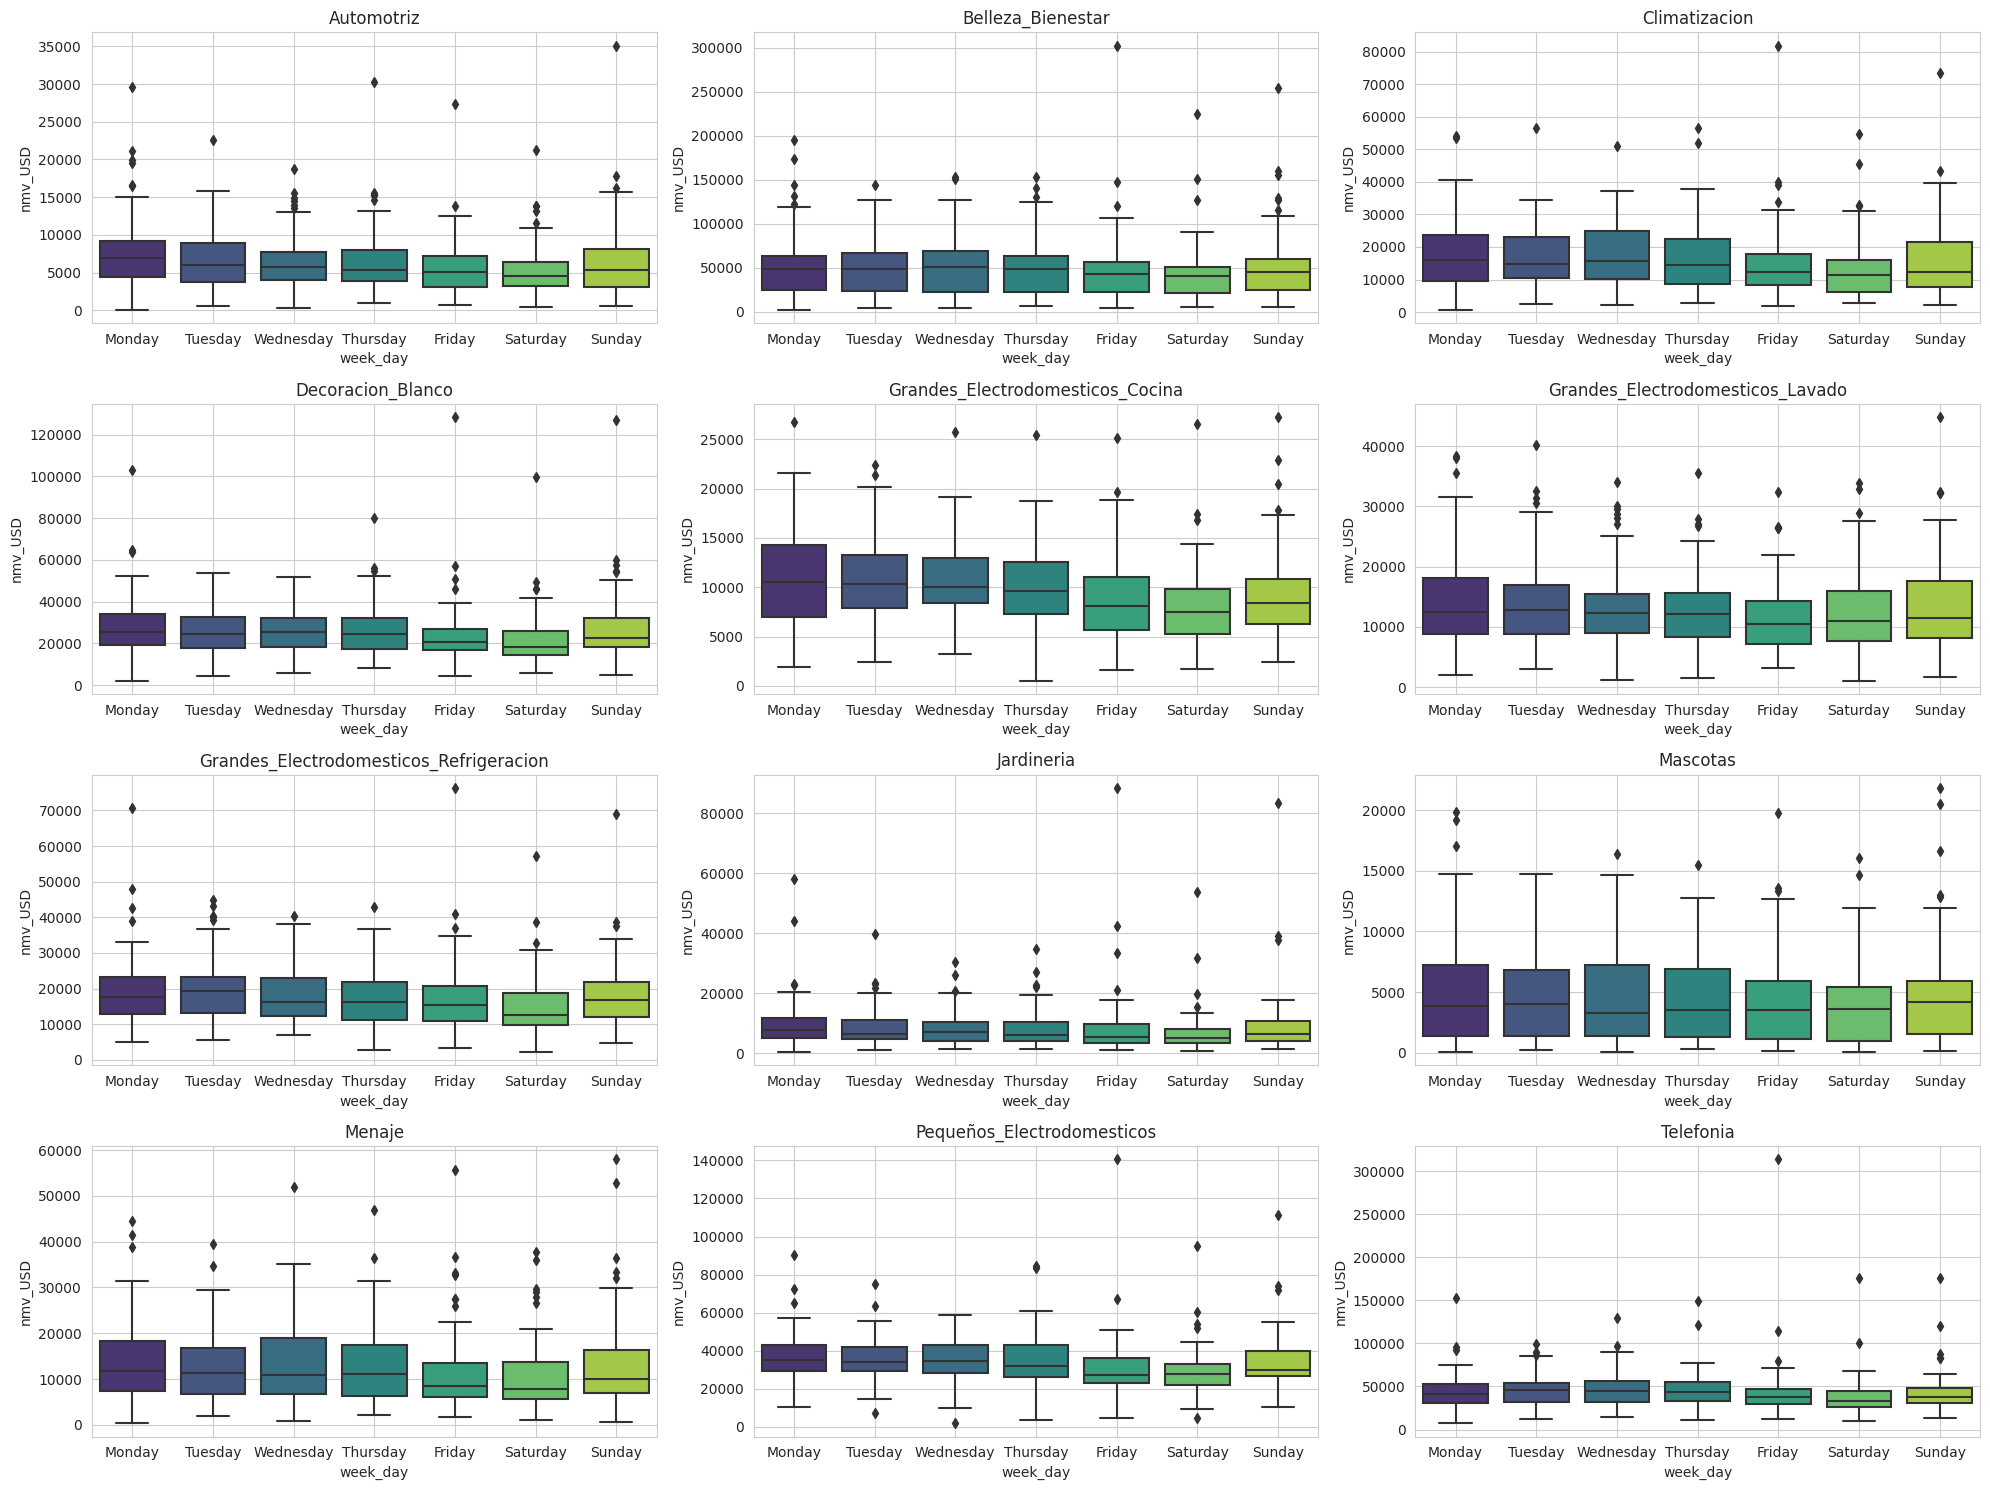

In [91]:
import calendar

day_names = list(calendar.day_name)

# Define the variable to graph
#x_ = 'budget_USD'
x_ = 'nmv_USD'

campaigns = df_raw['campaign'].unique()
cols = 3
rows = 4
fig, axs = plt.subplots(rows, cols, figsize=(20, 15))   #figsize=(35, 30)

for i, campaign in enumerate(campaigns):
    j = i // cols
    k = i % cols

    df3 = df2[df2['campaign'] == campaign]

    palette = sns.color_palette("viridis", n_colors=len(df3['week_day'].unique()))

    axs[j, k].set_title(campaign)
    sns.boxplot(data=df3, x='week_day', y=x_, palette=palette, ax=axs[j, k])
    axs[j, k].set_xticklabels(day_names)
    axs[j, k].set_ylabel(f'{x_}')
    axs[j, k].grid(True)

# Adjust the layout to avoid overlaps
plt.tight_layout()

# Show the graphs
plt.show()


#### NMV by month of the year

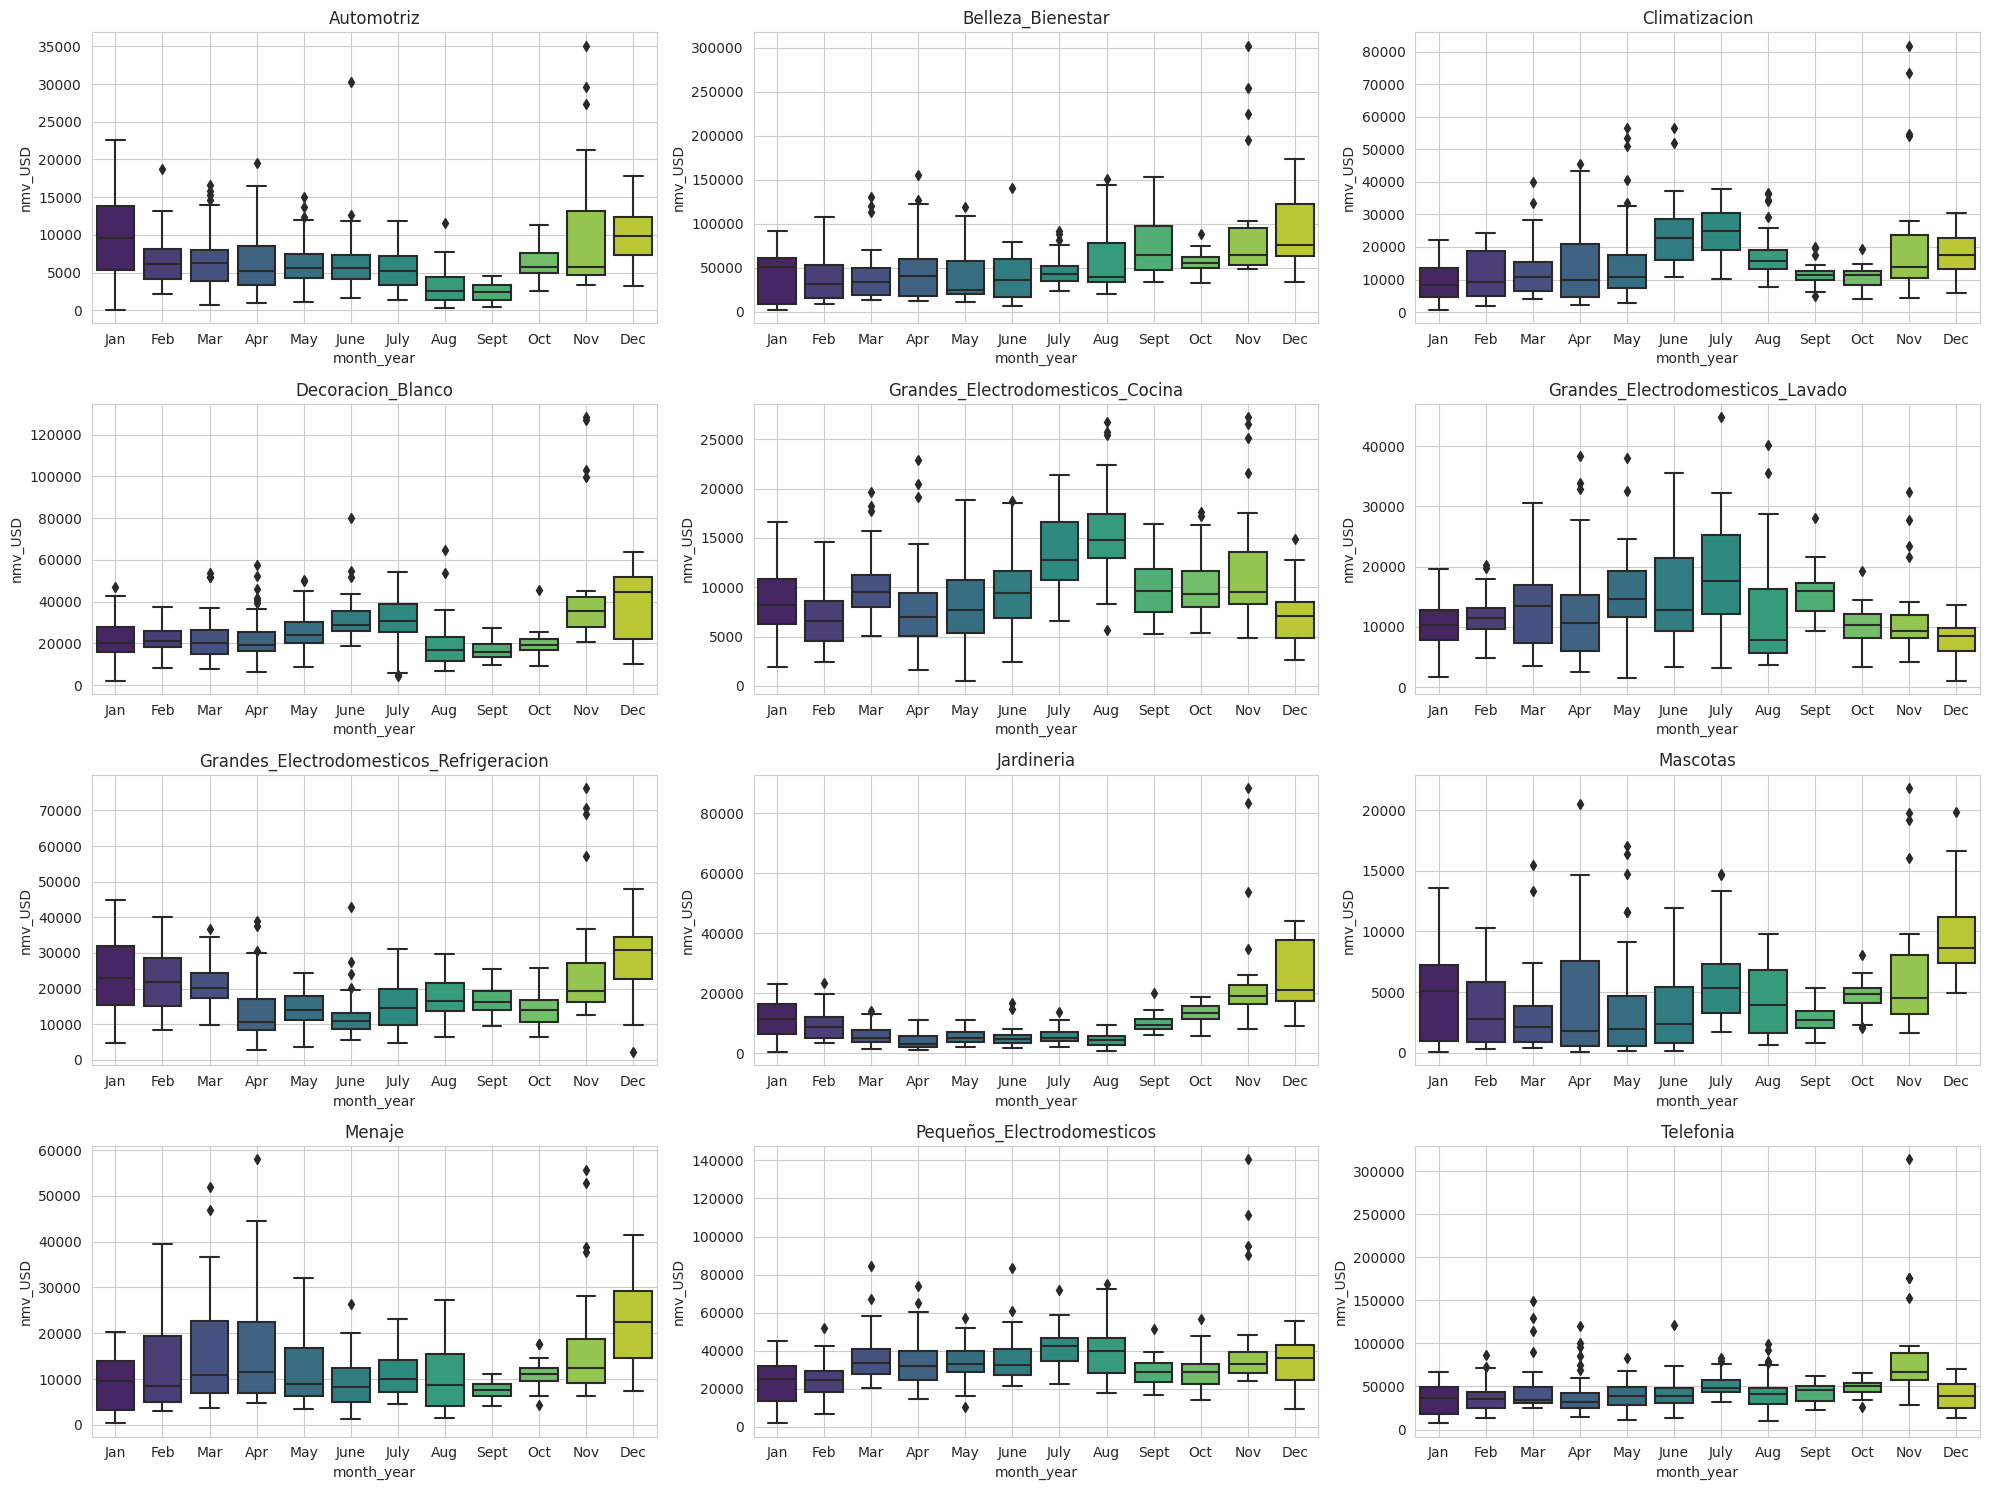

In [120]:
import calendar

#month_names = list(calendar.month_name)
month_names = ['',
 'Jan',
 'Feb',
 'Mar',
 'Apr',
 'May',
 'June',
 'July',
 'Aug',
 'Sept',
 'Oct',
 'Nov',
 'Dec']

# Define the variable to graph
# x_ = 'budget_USD'
x_ = 'nmv_USD'

campaigns = df_raw['campaign'].unique()
cols = 3
rows = 4
fig, axs = plt.subplots(rows, cols, figsize=(20, 15))  # figsize=(35, 30)

for i, campaign in enumerate(campaigns):
    j = i // cols
    k = i % cols

    df3 = df2[df2['campaign'] == campaign]

    palette = sns.color_palette("viridis", n_colors=len(df3['month_year'].unique()))

    axs[j, k].set_title(campaign)
    sns.boxplot(data=df3, x='month_year', y=x_, palette=palette, ax=axs[j, k])
    axs[j, k].set_xticklabels(month_names[1:])  # Excluye el nombre del mes vacío en la posición 0
    axs[j, k].set_ylabel(f'{x_}')
    axs[j, k].grid(True)

# Ajusta el diseño para evitar superposiciones
plt.tight_layout()

# Muestra los gráficos
plt.show()


#### NMV by day of the month

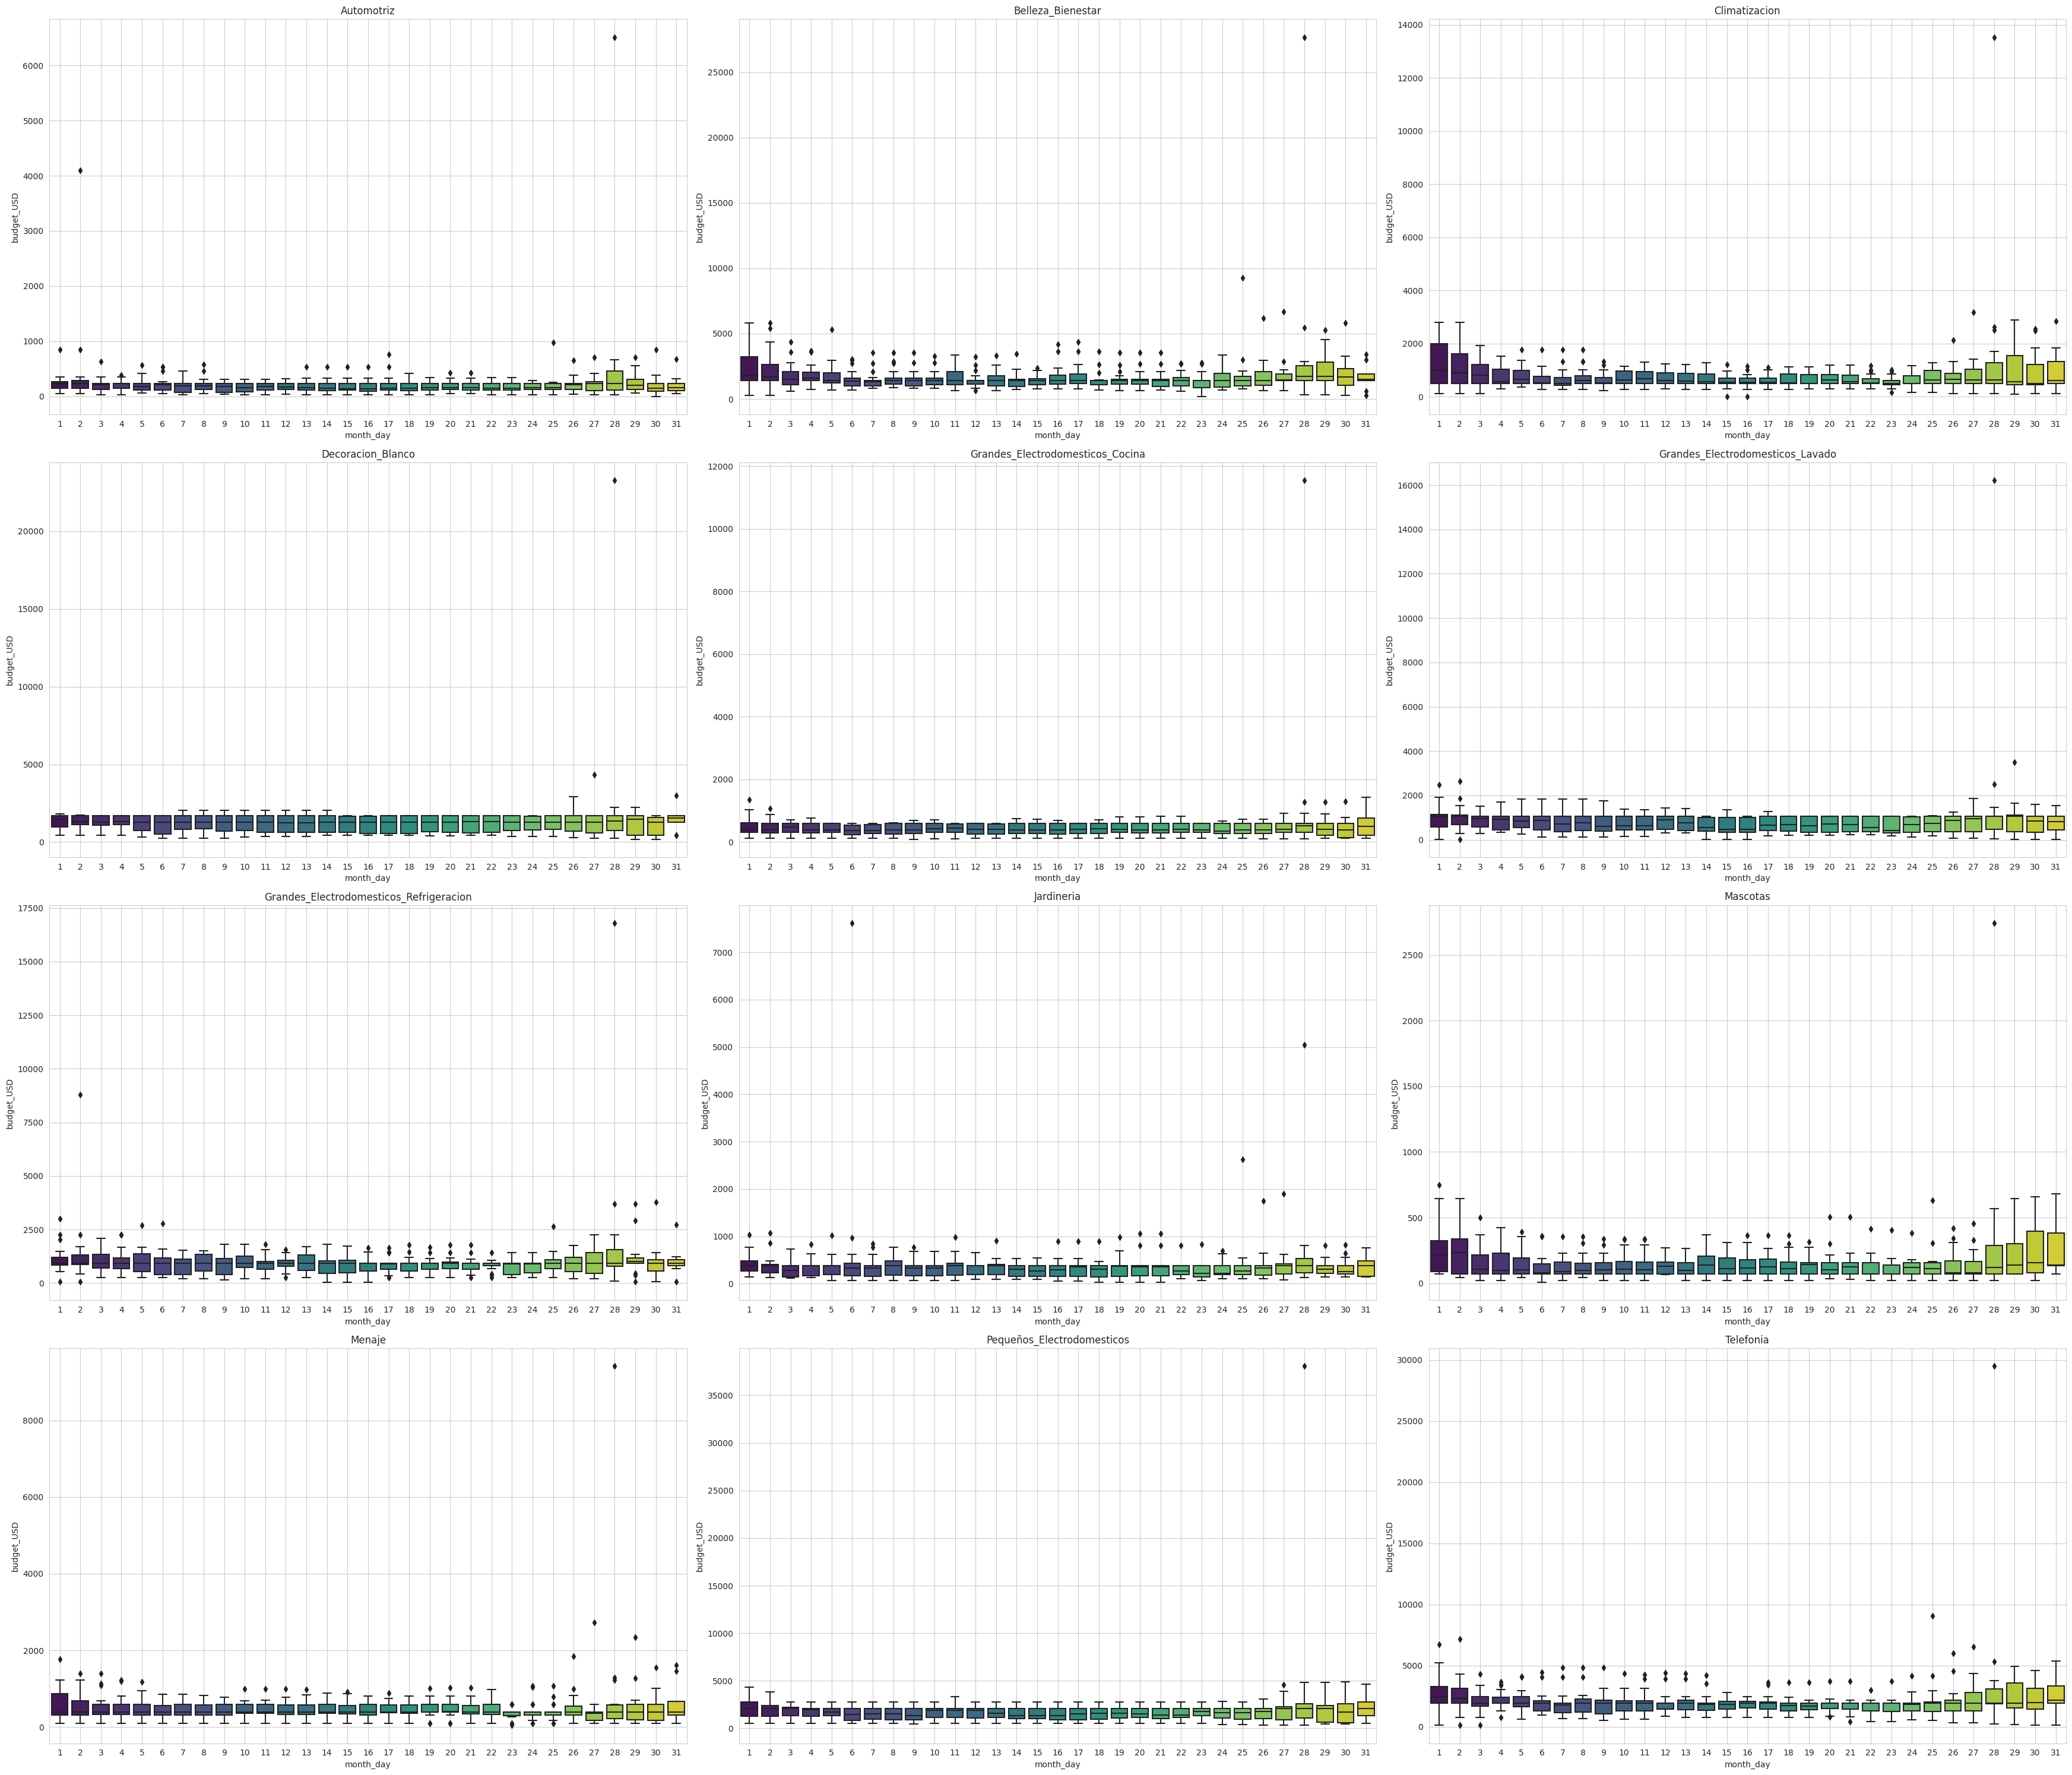

In [106]:
# Define the variable to graph
#x_ = 'nmv_USD'
x_ = 'budget_USD'

campaigns = df_raw['campaign'].unique()
cols = 3
rows = 4
fig, axs = plt.subplots(rows, cols, figsize=(35, 30))

for i, campaign in enumerate(campaigns):
    j = i // cols
    k = i % cols

    df3 = df2[df2['campaign'] == campaign]

    palette = sns.color_palette("viridis", n_colors=len(df3['month_day'].unique()))

    axs[j, k].set_title(campaign)
    sns.boxplot(data=df3, x='month_day', y=x_, palette=palette, ax=axs[j, k])
    axs[j, k].set_ylabel(f'{x_}')
    axs[j, k].grid(True)

# Adjust the layout to avoid overlaps
plt.tight_layout()

# Show the graphs
plt.show()


In [ ]:
#print(df_nout[(df_nout.date.between('2022-09-27','2022-10-02')) & (df_nout.campaign == 'Telefonia')][['date', 'campaign', 'budget_USD', 'nmv_USD', 'is_event', 'previous_cyber_days']])

#### NMV vs visits for weekend/no-weekend

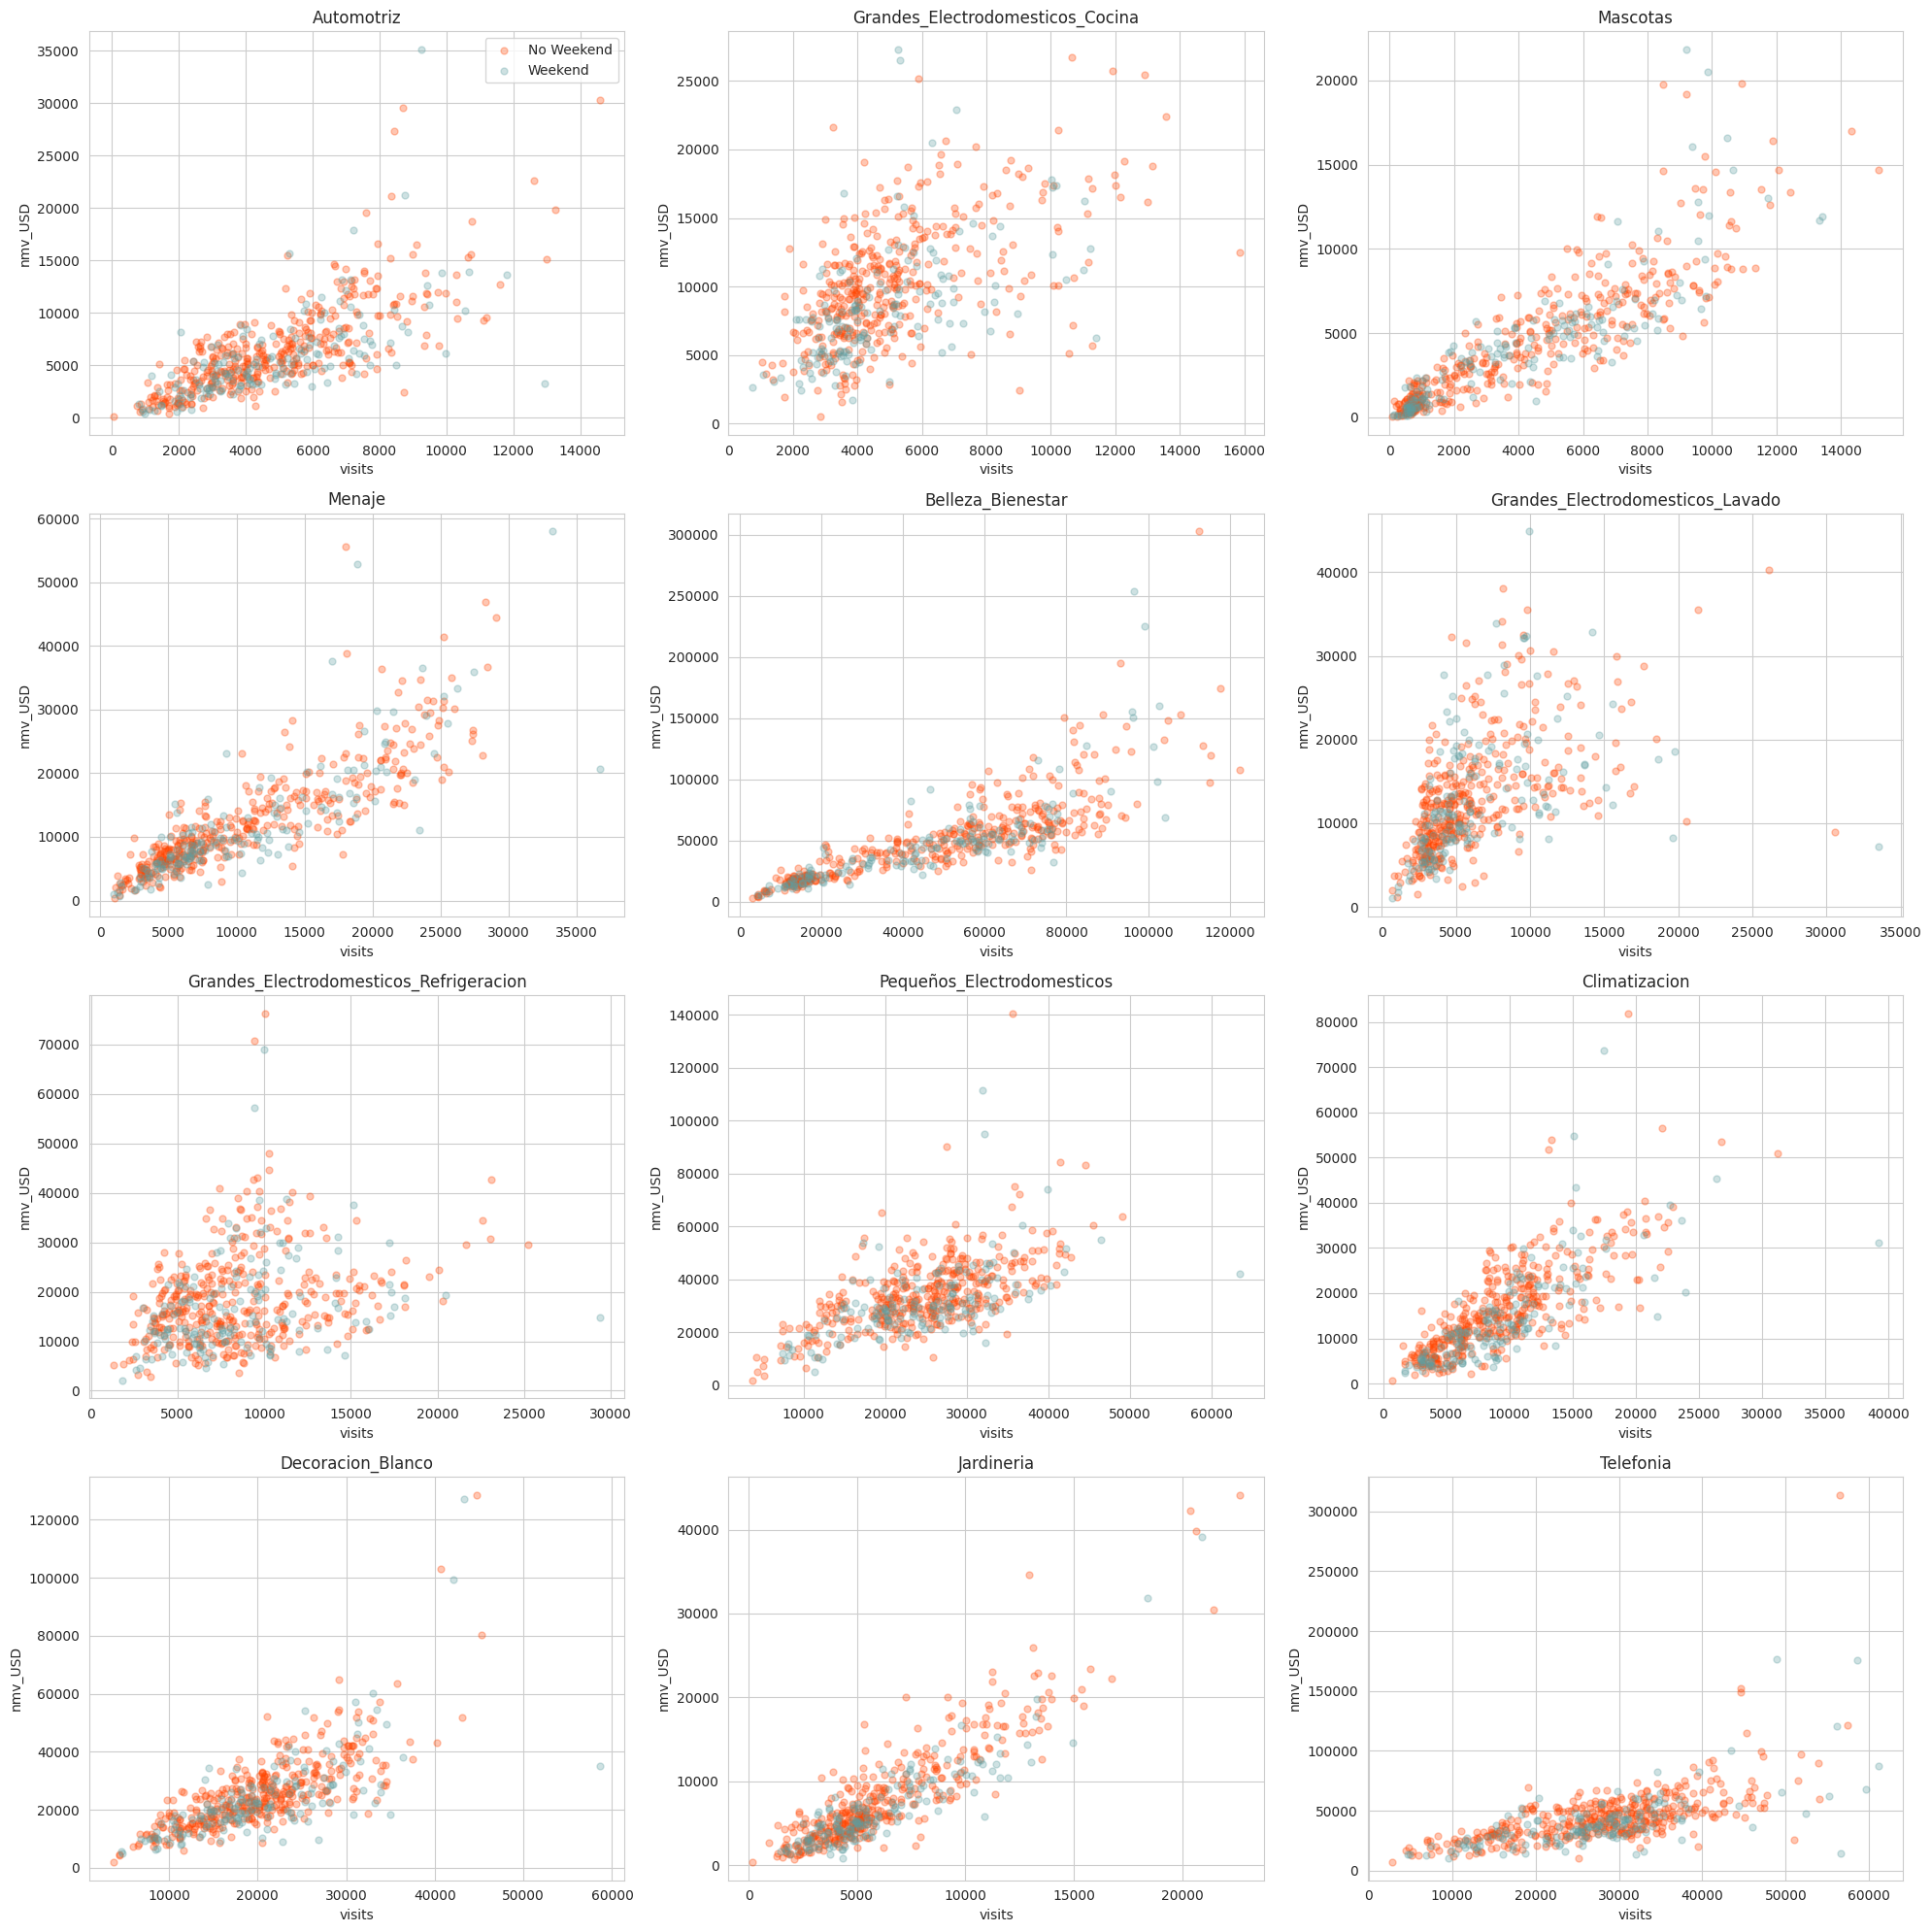

In [98]:
x_ = 'visits'
y_ = 'nmv_USD'


cols = 3
rows = 4
fig, axs = plt.subplots(rows, cols, figsize=(20,20))
fig.patch.set_facecolor('white')

for i, category in enumerate([*df_raw.campaign.unique()]):
    j = i%(rows)
    k = i%(cols)

    df3 = df2[(df2['campaign'] == category)] #& (df_raw['cost_USD'] > 0)]
    df3.dropna(inplace=True)

    dfe=df3[(df3.is_week_day==1)]
    dfne=df3[(df3.is_week_day==0)]
    #df.reset_index(inplace=True)
    axs[j,k].set_title(category)
    if (j==0)&(k==0):
        axs[j,k].scatter(dfe[x_],dfe[y_], s=25, color='orangered', alpha=0.3, label='No Weekend')
        axs[j,k].scatter(dfne[x_],dfne[y_], s=25, color='cadetblue', alpha=0.3, label='Weekend')
        axs[j,k].legend()
    else:
        axs[j,k].scatter(dfe[x_],dfe[y_], s=25, color='orangered', alpha=0.3)
        axs[j,k].scatter(dfne[x_],dfne[y_], s=25, color='cadetblue', alpha=0.3)
    axs[j,k].set_xlabel(f'{x_}')
    axs[j,k].set_ylabel(f'{y_}')
    axs[j,k].grid(True)
plt.tight_layout()

#### NMV vs budget for weekend/no-weekend

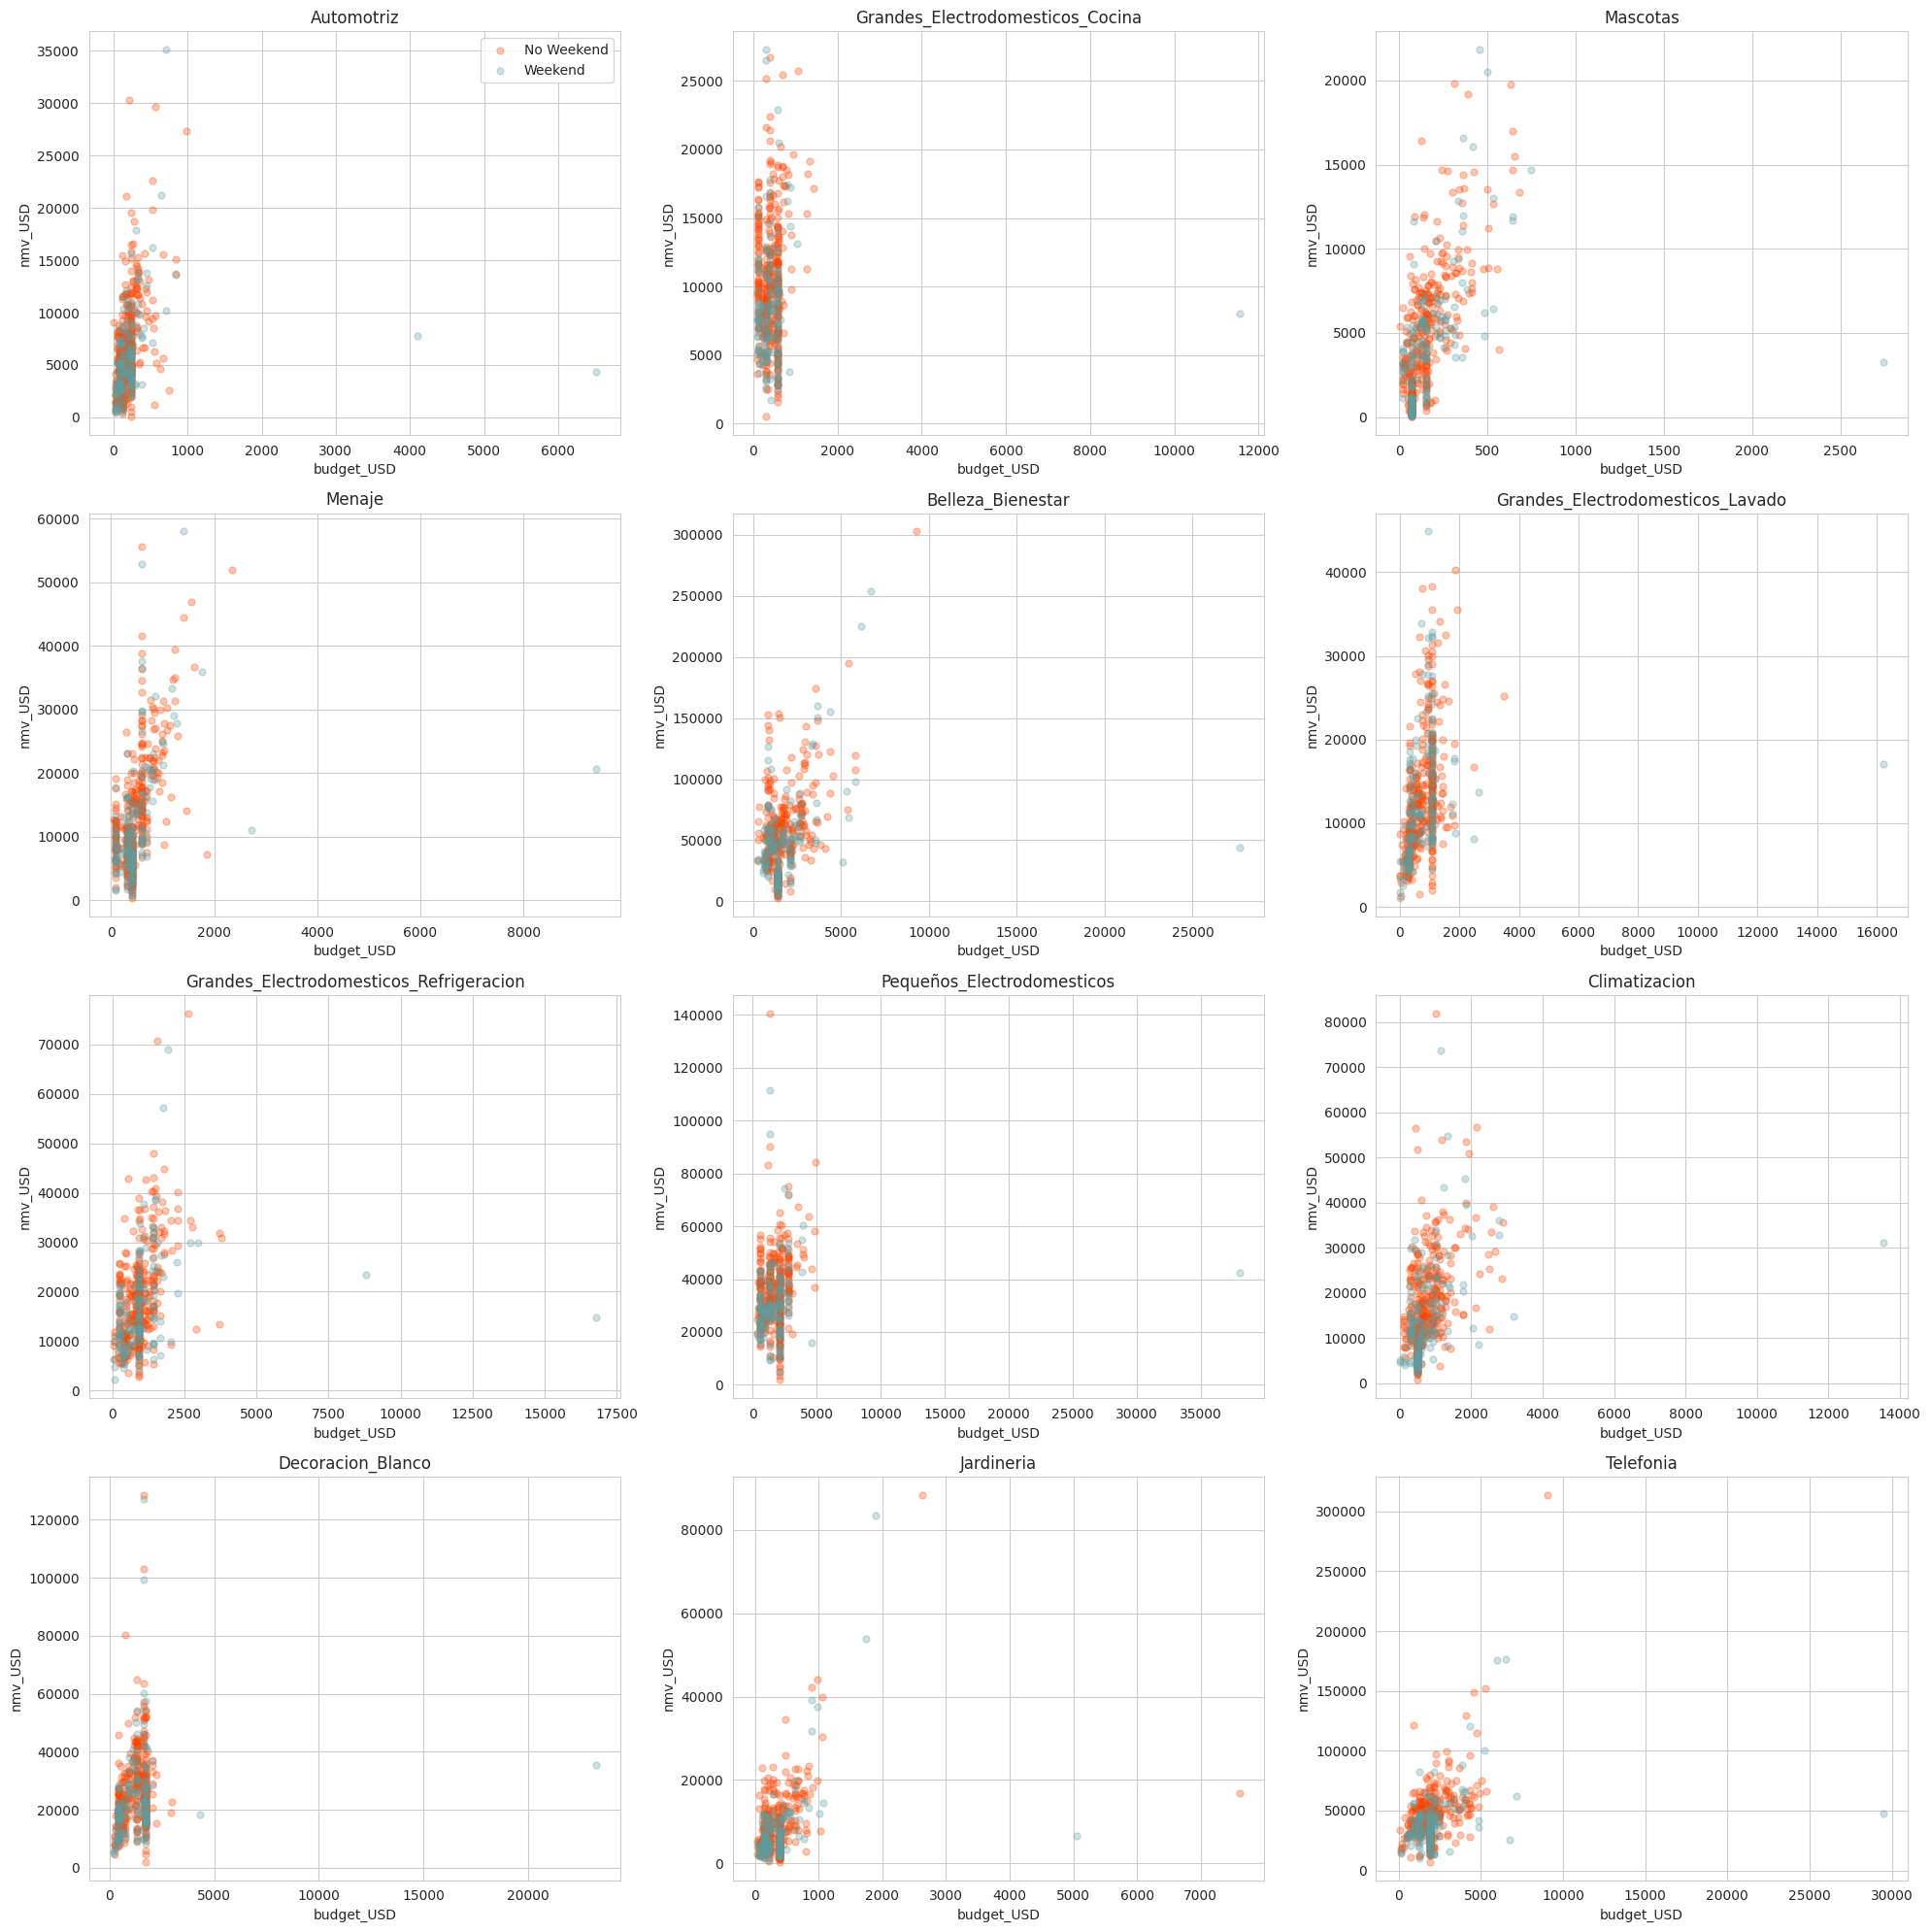

In [107]:
x_ = 'budget_USD'
y_ = 'nmv_USD'


cols = 3
rows = 4
fig, axs = plt.subplots(rows, cols, figsize=(20,20))
fig.patch.set_facecolor('white')

for i, category in enumerate([*df_raw.campaign.unique()]):
    j = i%(rows)
    k = i%(cols)

    df3 = df2[(df2['campaign'] == category)] #& (df_raw['cost_USD'] > 0)]
    df3.dropna(inplace=True)
    dfe=df3[(df3.is_week_day==1)]
    dfne=df3[(df3.is_week_day==0)]
    #df.reset_index(inplace=True)

    axs[j,k].set_title(category)
    if (j==0)&(k==0):
        axs[j,k].scatter(dfe[x_],dfe[y_], s=25, color='orangered', alpha=0.3, label='No Weekend')
        axs[j,k].scatter(dfne[x_],dfne[y_], s=25, color='cadetblue', alpha=0.3, label='Weekend')
        axs[j,k].legend()
    else:
        axs[j,k].scatter(dfe[x_],dfe[y_], s=25, color='orangered', alpha=0.3)
        axs[j,k].scatter(dfne[x_],dfne[y_], s=25, color='cadetblue', alpha=0.3)
    axs[j,k].set_xlabel(f'{x_}')
    axs[j,k].set_ylabel(f'{y_}')
    axs[j,k].grid(True)
plt.tight_layout()

#### NMV vs budget for event/no-event

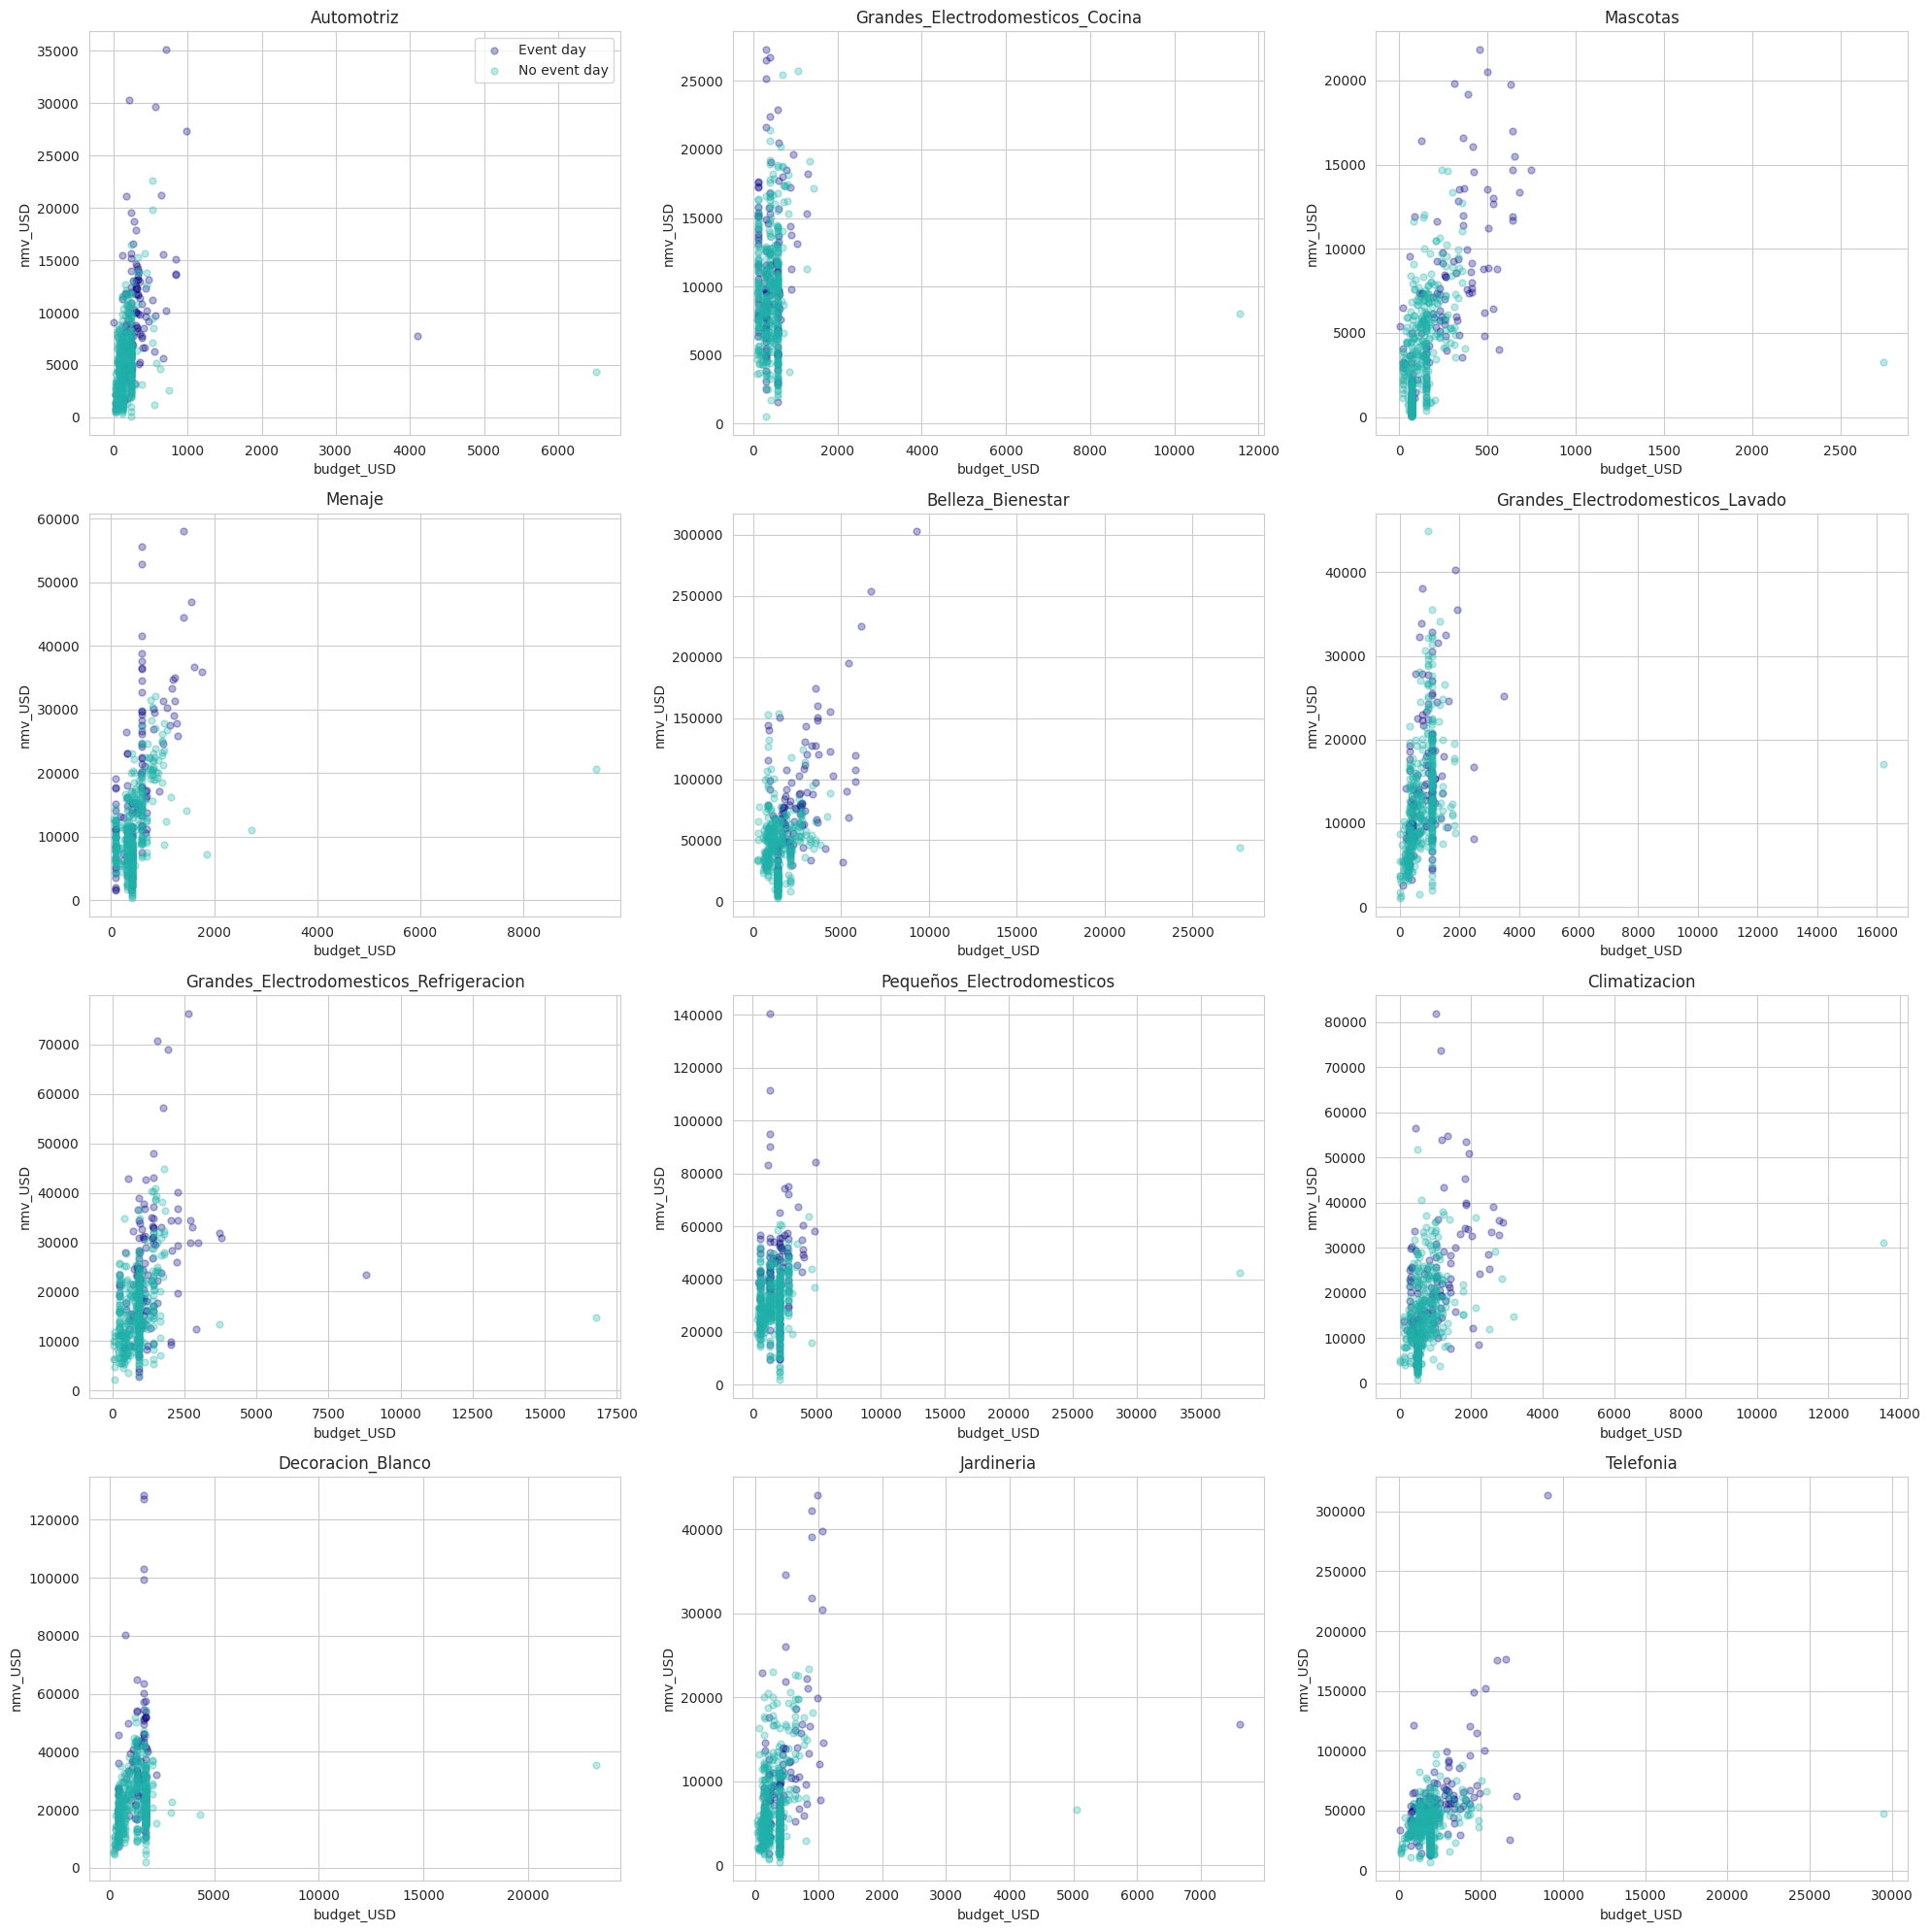

In [100]:
x_ = 'budget_USD'
y_ = 'nmv_USD'


cols = 3
rows = 4
fig, axs = plt.subplots(rows, cols, figsize=(20,20))
fig.patch.set_facecolor('white')

for i, category in enumerate([*df_raw.campaign.unique()]):
    j = i%(rows)
    k = i%(cols)

    df3 = df2[(df2['campaign'] == category)] #& (df_raw['cost_USD'] > 0)]
    df3.dropna(inplace=True)
    dfe=df3[(df3.is_event==1)]
    dfne=df3[(df3.is_event==0)]
    #df.reset_index(inplace=True)

    axs[j,k].set_title(category)
    if (j==0)&(k==0):
        axs[j,k].scatter(dfe[x_],dfe[y_], s=25, color='navy', alpha=0.3, label='Event day')
        axs[j,k].scatter(dfne[x_],dfne[y_], s=25, color='lightseagreen', alpha=0.3, label='No event day')
        axs[j,k].legend()
    else:
        axs[j,k].scatter(dfe[x_],dfe[y_], s=25, color='navy', alpha=0.3)
        axs[j,k].scatter(dfne[x_],dfne[y_], s=25, color='lightseagreen', alpha=0.3)
    axs[j,k].set_xlabel(f'{x_}')
    axs[j,k].set_ylabel(f'{y_}')
    axs[j,k].grid(True)
plt.tight_layout()

#### NMV distribution over time by campaign distinguishing by event / no-event day

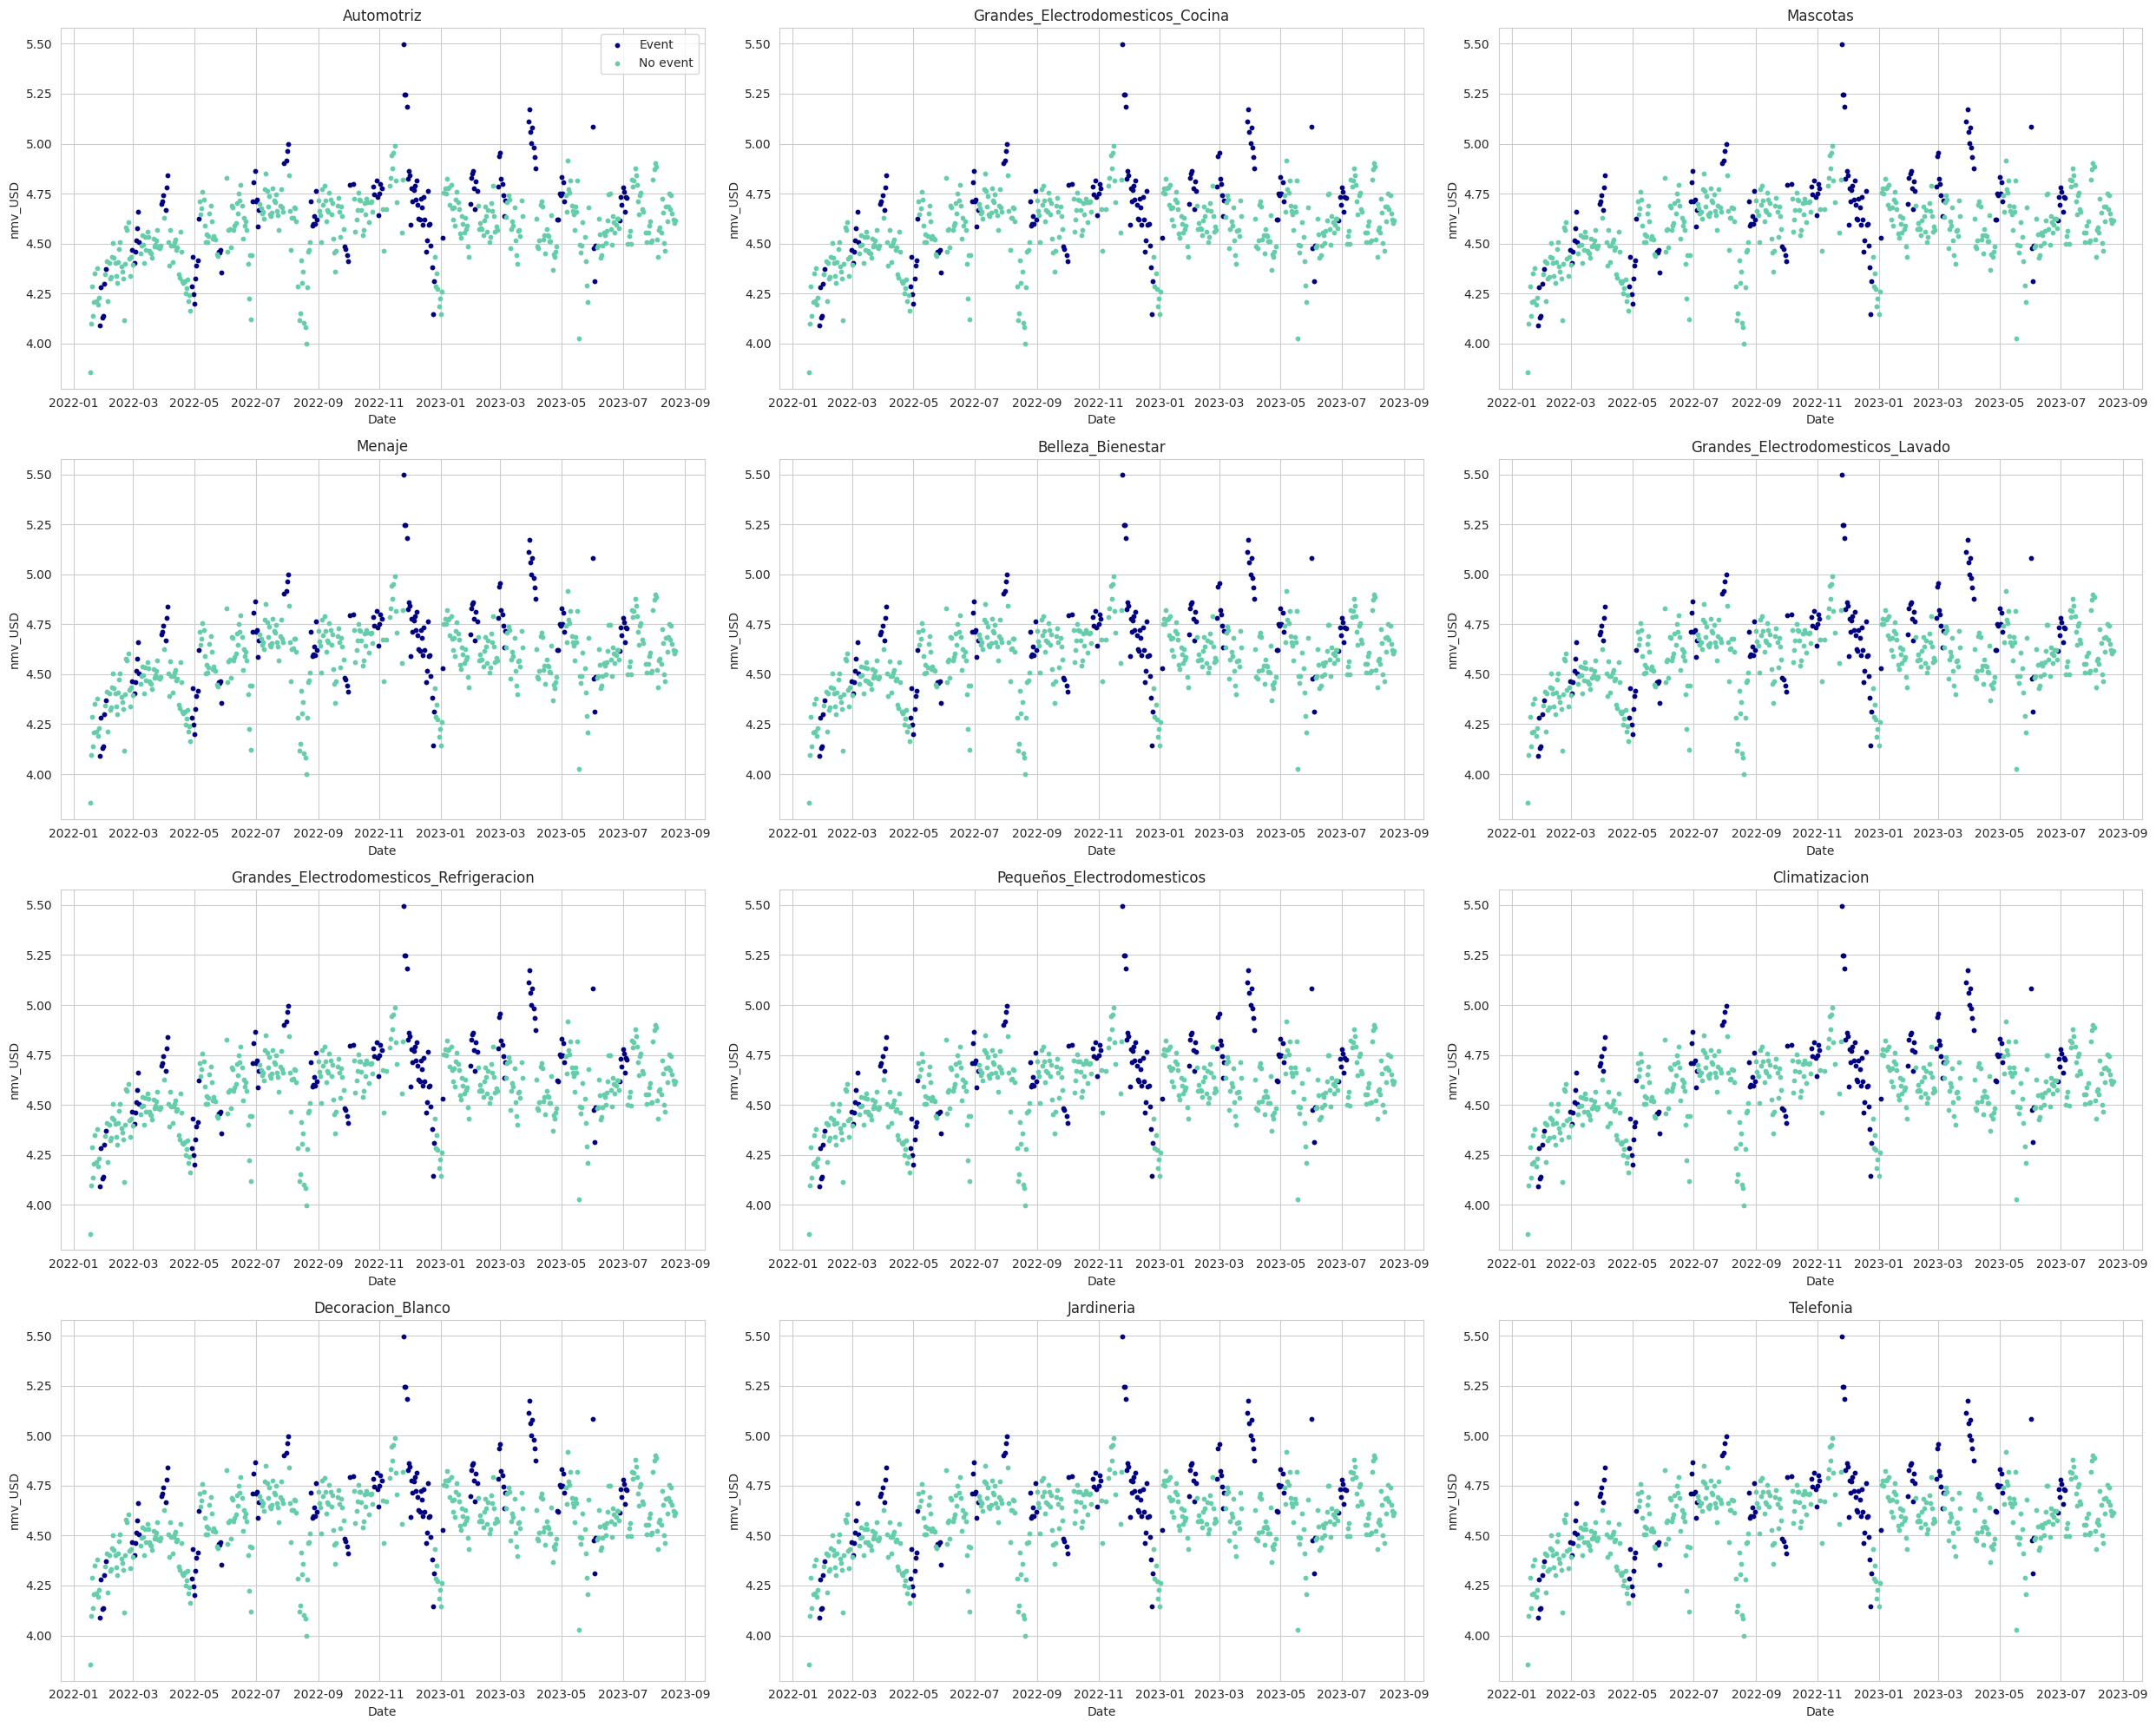

In [112]:
# Define the variable to graph
y_ = 'nmv_USD'
#y_ = 'budget_USD'

cols = 3
rows = 4
fig, axs = plt.subplots(rows, cols, figsize=(25,20))
sns.set_style('whitegrid')

for i, campaign in enumerate([*df_raw.campaign.unique()]):
    j = i%(rows)
    k = i%(cols)

    df3 = df2[(df2['campaign'] == category)]
    df3.dropna(inplace=True)
    dfev=df3[(df3.is_event==1)]
    dfne=df3[(df3.is_event==0)]

    axs[j,k].set_title(campaign)
    if (j==0)&(k==0):
        axs[j,k].scatter(dfev.index, np.log10(1.0 + dfev[y_]), s=10, color='navy', label='Event')
        axs[j,k].scatter(dfne.index, np.log10(1.0 + dfne[y_]), s=10, color='mediumaquamarine', label='No event')
        axs[j,k].legend()
    else:
        if (j==0)&(k==1):
            axs[j,k].scatter(dfev.index, np.log10(1.0 + dfev[y_]), s=10, color='navy')
            axs[j,k].scatter(dfne.index, np.log10(1.0 + dfne[y_]), s=10, color='mediumaquamarine')
        else:
            axs[j,k].scatter(dfev.index, np.log10(1.0 + dfev[y_]), s=10, color='navy') #'skyblue'
            axs[j,k].scatter(dfne.index, np.log10(1.0 + dfne[y_]), s=10, color='mediumaquamarine')

    axs[j,k].set_xlabel('Date')
    axs[j,k].set_ylabel(f'{y_}')
    axs[j,k].grid(True)
plt.tight_layout()

#### NMV distribution over time for *X* campaign

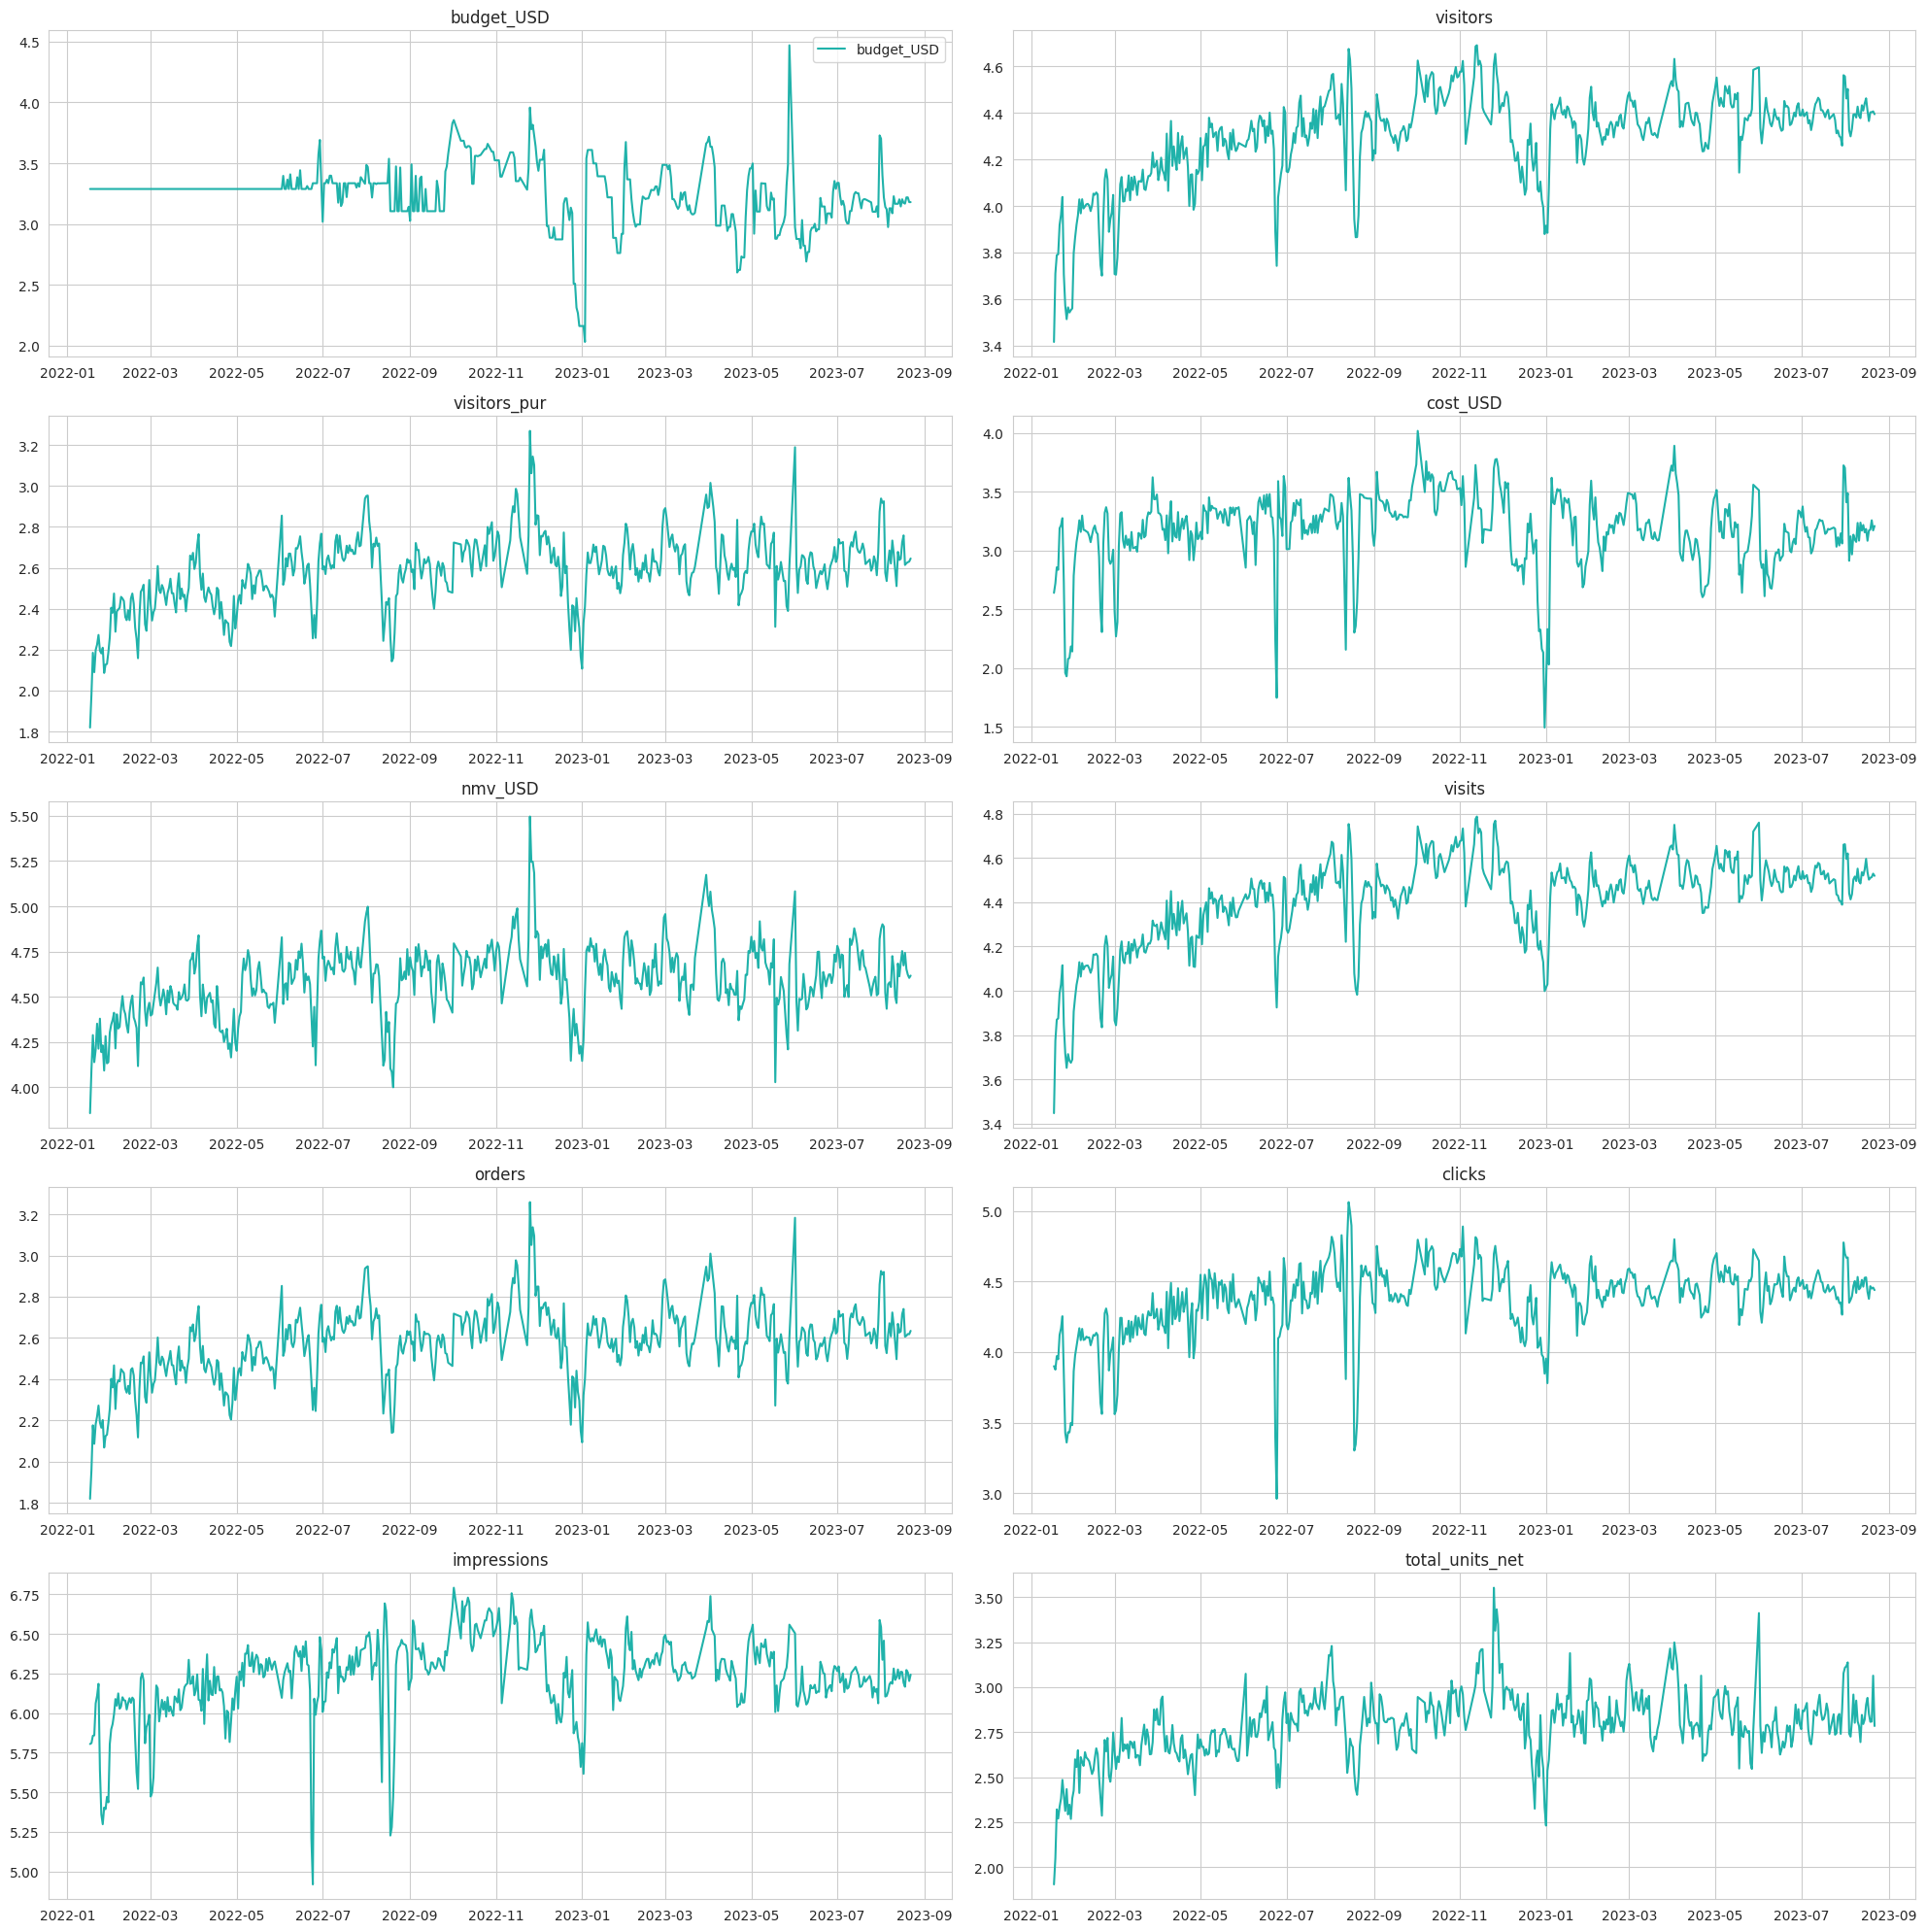

In [101]:
# Variables to plot
variables = ['budget_USD','cost_USD','nmv_USD','clicks','impressions','visitors','visitors_pur','visits','orders','total_units_net']

cols = 2
rows = 5
fig, axs = plt.subplots(rows, cols, figsize=(20,20))
sns.set_style('whitegrid')

# Iterate through each variable and plot the box plot in the corresponding subplot
for i, var in enumerate(variables):
    j = i%(rows)
    k = i%(cols)

    df3 = df2[df2.campaign == 'Telefonia']

    axs[j,k].set_title(var)
    # I want the legend in the 1rst graph only
    if (j==0)&(k==0):
        axs[j,k].plot(df3.index, np.log10(1.0+df3[var]), label= f'{var}', color='lightseagreen')
        axs[j,k].legend()
    else:
        axs[j,k].plot(df3.index, np.log10(1.0+df3[var]), color='lightseagreen')

    axs[j,k].grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

### Transform char variable

In [71]:
# One-hot Encoder
column = 'campaign'
campaigns = df2[column]
df_final = pd.get_dummies(df2, prefix=[column], columns = [column], drop_first=False)
df_final[column] = campaigns

print(df_final.shape)
df_final.head()

(6633, 30)


week_day  month_day  year_day  month_year  is_event  \
date                                                              
2022-01-17         1         17        17           1         0   
2022-01-18         2         18        18           1         0   
2022-01-19         3         19        19           1         0   
2022-01-20         4         20        20           1         0   
2022-01-21         5         21        21           1         0   

            previous_cyber_days  clicks  impressions  visitors  visitors_pur  \
date                                                                           
2022-01-17                    0     354        39672        42             3   
2022-01-18                    0    1254       109474       763            11   
2022-01-19                    0    4344       124152      1032            14   
2022-01-20                    0    7231       413879      3120            38   
2022-01-21                    0   34950      1170805      8004            41   

            ...  campaign_Decoracion_Blanco  \
date        ...                               
2022-01-17  ...                           0   
2022-01-18  ...                           0   
2022-01-19  ...                           0   
2022-01-20  ...                           0   
2022-01-21  ...                           0   

            campaign_Grandes_Electrodomesticos_Cocina  \
date                                                    
2022-01-17                                          0   
2022-01-18                                          0   
2022-01-19                                          0   
2022-01-20                                          0   
2022-01-21                                          0   

            campaign_Grandes_Electrodomesticos_Lavado  \
date                                                    
2022-01-17                                          0   
2022-01-18                                          0   
2022-01-19                                          0   
2022-01-20                                          0   
2022-01-21                                          0   

            campaign_Grandes_Electrodomesticos_Refrigeracion  \
date                                                           
2022-01-17                                                 0   
2022-01-18                                                 0   
2022-01-19                                                 0   
2022-01-20                                                 0   
2022-01-21                                                 0   

            campaign_Jardineria  campaign_Mascotas  campaign_Menaje  \
date                                                                  
2022-01-17                    0                  0                0   
2022-01-18                    0                  0                0   
2022-01-19                    0                  0                0   
2022-01-20                    0                  0                0   
2022-01-21                    0                  0                0   

            campaign_Pequeños_Electrodomesticos  campaign_Telefonia  \
date                                                                  
2022-01-17                                    0                   0   
2022-01-18                                    0                   0   
2022-01-19                                    0                   0   
2022-01-20                                    0                   0   
2022-01-21                                    0                   0   

              campaign  
date                    
2022-01-17  Automotriz  
2022-01-18  Automotriz  
2022-01-19  Automotriz  
2022-01-20  Automotriz  
2022-01-21  Automotriz  

[5 rows x 30 columns]

In [122]:
## Dummy size check by campaign
df_final[(df_final.campaign == 'Belleza_Bienestar')|(df_final.campaign == 'Jardineria')|(df_final.campaign == 'Telefonia')].\
groupby(['campaign', 'campaign_Telefonia']).size().reset_index(name='frequency')

campaign  campaign_Telefonia  frequency
0  Belleza_Bienestar                   0        553
1         Jardineria                   0        553
2          Telefonia                   1        552

In [123]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6633 entries, 2022-01-17 to 2023-08-22
Data columns (total 30 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   week_day                                          6633 non-null   int64  
 1   month_day                                         6633 non-null   int64  
 2   year_day                                          6633 non-null   int64  
 3   month_year                                        6633 non-null   int64  
 4   is_event                                          6633 non-null   int64  
 5   previous_cyber_days                               6633 non-null   int64  
 6   clicks                                            6633 non-null   int64  
 7   impressions                                       6633 non-null   int64  
 8   visitors                                          6633 non-null   int64  
 9   v

### Export final dataframe


1.   Money fields modified to USD
2.   Outliers removed
3.   Cyber days removed
4.   Enconde campaign

### Final clean dataframe name: **df_final**




In [124]:
## Save parquet file into temporary enviroment
df_final.to_parquet('/content/drive/MyDrive/UNR_2023/01.Open data/data_NMV_GAds_clean.parquet', index=False)